# **Learning from Imbalanced Datasets** <a class="anchor" id="0.1"></a>

February 7, 2022


### Description

Imbalanced datasets are those in which the classes are not represented equally, which results in classifiers disregarding the minority class. Typical ways of dealing with this issue are resampling the dataset (either upsampling the minority class/es or downsampling the majority class/es. In this project, you will test a new approach to dealing with imbalanced datasets, based on a mixture of supervised and unsupervised learning.

### Tasks

1. Choose 3 datasets from UCI, Kaggle, etc. You will make them imbalanced, so make sure they are not imbalanced from the beginning. Small imbalances (e.g., 55% of one class) are fine. Load, inspect, and clean the datasets. For each of them, create three versions/surrogates (in addition to the original one) by subsampling one of the classes:
    1. Low imbalance (65%)
    1. Medium imbalance (75%)
    1. High imbalance (90%)
1. To establish a baseline, perform stratified cross-validation on each of the datasets and their surrogates and train a random forest. Report baseline results using appropriate metrics.
1. Create 10 stratified folds (to ensure the imbalance ratio remains the same in each fold) for each of the datasets.

1. Using the data of 9 of these folds:
    1. Using the Elbow method and the Silhouette method, identify the number of clusters in the dataset.There should be some level of agreement between these indices (or at least you should be able to identify lower and upper bounds).
    1. Run k-means in the data set using the identified number of clusters. Select as final clustering that with the lowest output criteria.
    1. For each cluster, identify its centroid and the number of samples of the minority class in that cluster (as per their labels). Save this information.
    1. Train a random forest for each of the clusters that contains samples from more than one class (i.e., if a cluster only has samples for one of the classes, you don’t need to train a classifier).
    1. Given a sample xi from the unseen fold (the one left out in (3))
        1. Assign xi to its closest cluster.
        1. this cluster has only instances of one class, assign to xi that label. Otherwise, use the model trained with data from that cluster to assign a label to xi
.
1. Do the above for each permutation of 10 bins (like in cross-validation), and present the average and standard deviation of results for each of the datasets and their surrogates using appropriate metric/s.
1. Compare your results with the baseline results from (2). A boxplot of the cross-validation results for each method should help you decide which method is best under which conditions. Are the results significantly better with the new method (e.g., as determined by a permutation test)? How does the data imbalance affect the results?

# **Table of Contents** <a class="anchor" id="0"></a>
1. [Task 01](#1)
    1. [Import Libraries](#1.1)
    1. [Loading Data](#1.2)
    1. [Data Content](#1.3)
    1. [Analzying Data](#1.4)
    1. [Missing Value Analysis](#1.5)
    1. [Unique Value Analysis](#1.6)
    1. [Categorical Feature Analysis](#1.7)
    1. [Numeric Feature Analysis](#1.8)
    1. [Standardization](#1.9)
    1. [Box Plot Analysis](#1.10)
    1. [Swarm Plot Analysis](#1.11)
    1. [Cat Plot Analysis](#1.12)
    1. [Correlation Analysis](#1.13)
    1. [Outlier Detection](#1.14)
    1. [Data Imbalancing](#1.15)
        1. [Low Imbalance dataset (65% and 35%)](#1.15.1)
        1. [Medium Imbalance dataset (75% and 25%)](#1.15.2)
        1. [High Imbalance dataset (90% and 10%)](#1.15.3)
1. [Task 02](#2)        
    1. [Encoding Categorical Column](#2.1)
    1. [Declare feature vector and target variable, Normalization and Train - Test Split](#2.2)
    1. [Random Forest Classifier](#2.3)
1. [Task 03](#3)     
    1. [Stratify 10 Fold](#3.1)
1. [Task 04](#4)
    1. [Optimal number of clusters](#4.1)
        1. [Silhouette analysis to find optimal number of clusters](#4.1.1)
        1. [Elbow method to find optimal number of clusters](#4.1.2)
    1. [KMeans Cluster](#4.2) 
    1. [Identify its centroid](#4.3) 
    1. [Train a random forest for each of the clusters](#4.4)  
    1. [Working on unseen fold (the one left out in (3)](#4.5)
1. [Task 05](#5)
1. [Task 06](#6)

## Task 01 <a class="anchor" id="1"></a>
[Table of Contents](#0)

Choose 3 datasets from UCI, Kaggle, etc. You will make them imbalanced, so make sure they are not imbalanced from the beginning. Small imbalances (e.g., 55% of one class) are fine. Load, inspect, and clean the datasets. For each of them, create three versions/surrogates (in addition to the original one) by subsampling one of the classes:

    Low imbalance (65%)
    Medium imbalance (75%)
    High imbalance (90%)

### Import Libraries<a class="anchor" id="1.1"></a>
[Task 01](#1)

In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from scipy.stats import pearsonr
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score, permutation_test_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve,  precision_score, confusion_matrix, silhouette_samples, silhouette_score

from sklearn.metrics import roc_curve, auc, precision_recall_curve,  average_precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

### Loading Data<a class="anchor" id="1.2"></a>
[Task 01](#1)

In [163]:
#Reading data
df = pd.read_csv("heart.csv")
df


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [164]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Data Content <a class="anchor" id="1.3"></a>
[Task 01](#1)

* **Age**: Age of the patient
* **Sex**: Sex of the patient
* **exang**: exercise induced angina (1 = yes; 0 = no)
* **ca**: number of major vessels (0-3)
* **cp**: Chest Pain type chest pain type
    * Value 1: typical angina
    * Value 2: atypical angina
    * Value 3: non-anginal pain
    * Value 4: asymptomatic
* **trtbps**: resting blood pressure (in mm Hg)
* **chol**: cholestoral in mg/dl fetched via BMI sensor
* **fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* **rest_ecg**: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalach**: maximum heart rate achieved
* **target**: 0= less chance of heart attack 1= more chance of heart attack

### Analzying Data<a class="anchor" id="1.4"></a>
[Task 01](#1)

In [165]:
#Basic Stats about data
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [166]:
#Information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Missing Value Analysis<a class="anchor" id="1.5"></a>
[Task 01](#1)

In [167]:
#Missing Value
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

### Unique Value Analysis<a class="anchor" id="1.6"></a>
[Task 01](#1)

In [168]:
for i in list(df.columns):
    print("{} -- {}". format(i, df[i].value_counts().shape[0]))

age -- 41
sex -- 2
cp -- 4
trtbps -- 49
chol -- 152
fbs -- 2
restecg -- 3
thalachh -- 91
exng -- 2
oldpeak -- 40
slp -- 3
caa -- 5
thall -- 4
output -- 2


### Categorical Feature Analysis<a class="anchor" id="1.7"></a>
[Task 01](#1)

In [169]:
categorical_list = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall", "output"]

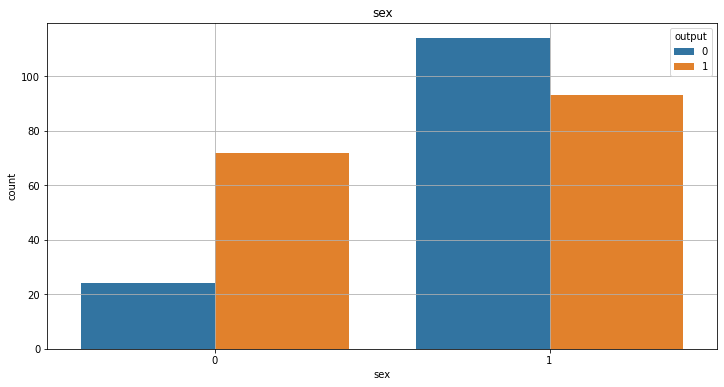

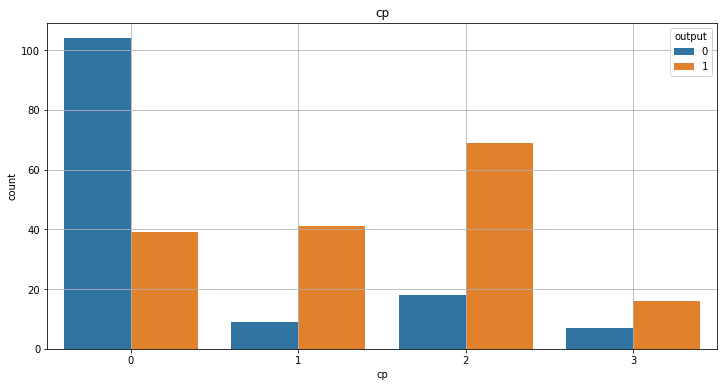

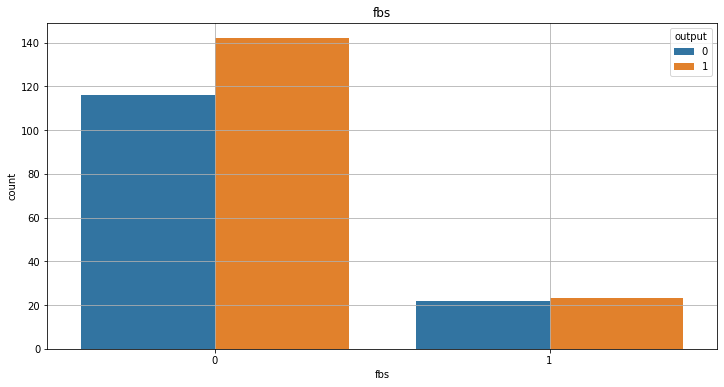

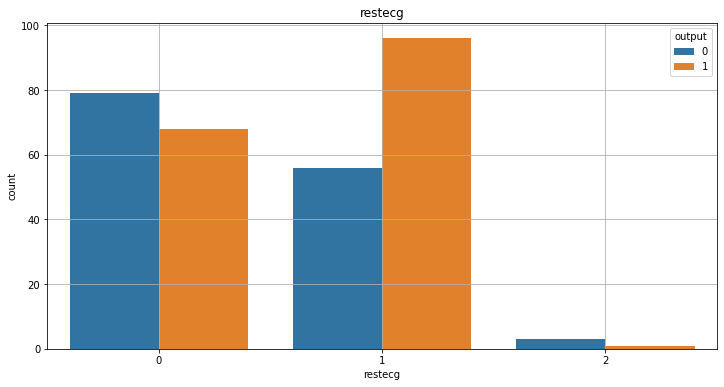

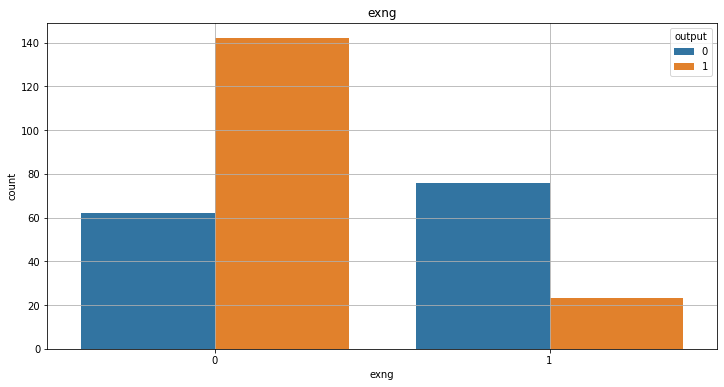

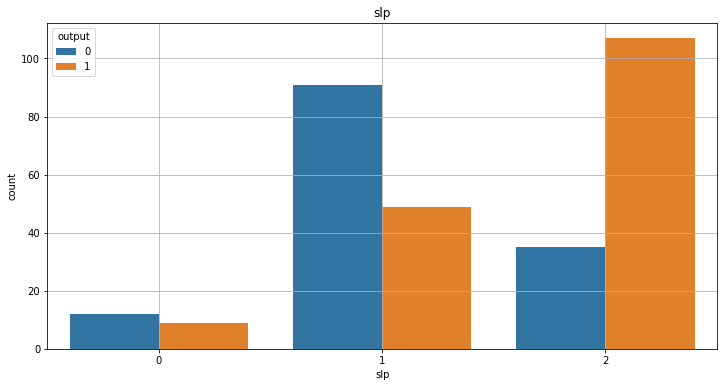

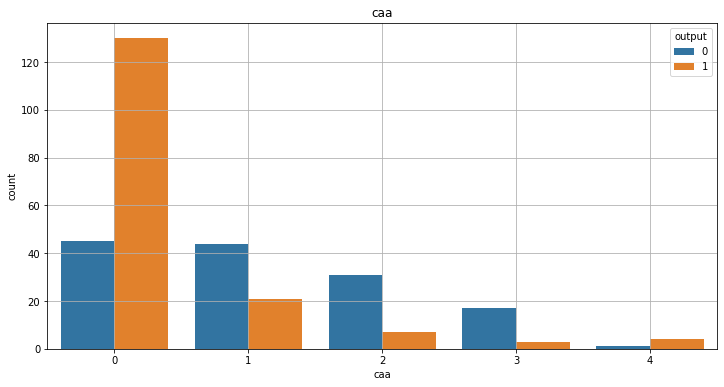

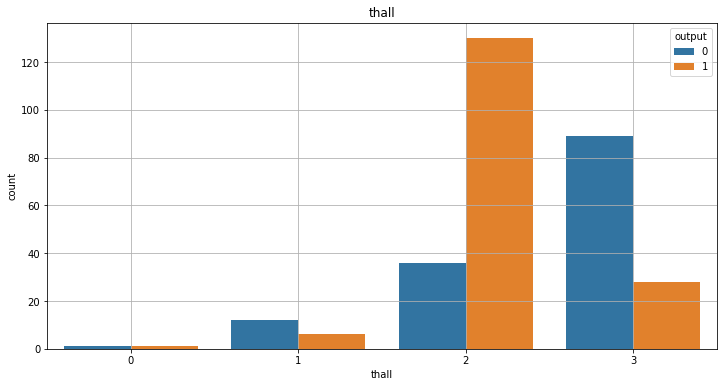

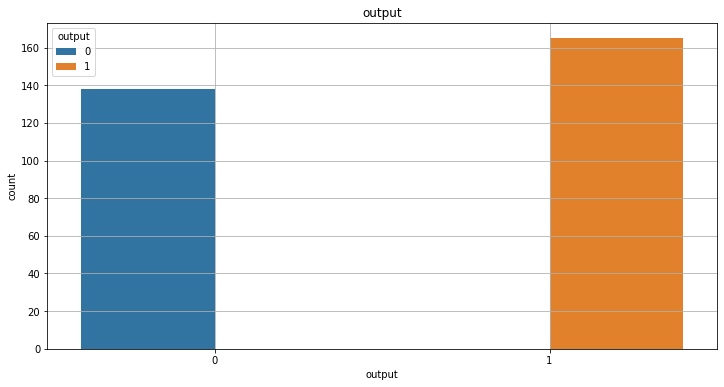

In [170]:
df_categoric = df.loc[:, categorical_list]

for i in categorical_list:
    plt.figure(figsize = (12, 6))
    sns.countplot(x = i, data = df_categoric, hue = "output")
    plt.grid()
    plt.title(i)

### Numeric Feature Analysis<a class="anchor" id="1.8"></a>
[Task 01](#1)

* Bivariate data analysis with scatter plot

In [171]:
numeric_list = ["age", "trtbps", "chol", "thalachh", "oldpeak", "output"]

<Figure size 864x432 with 0 Axes>

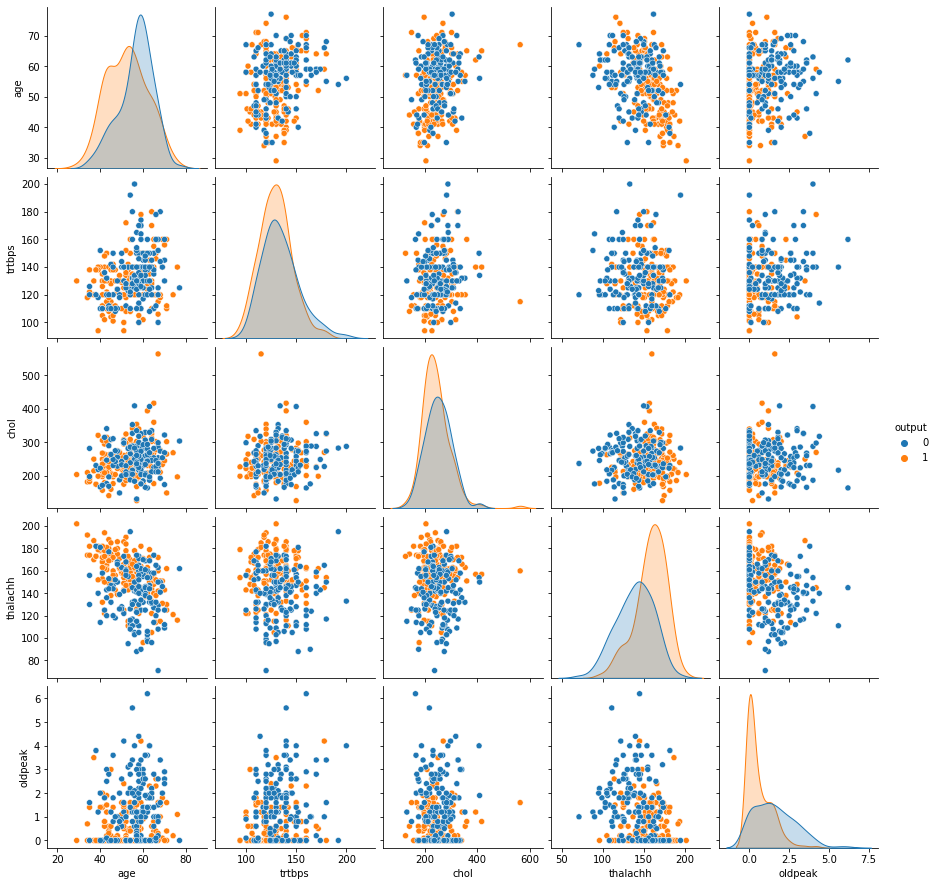

In [172]:
df_numeric = df.loc[:, numeric_list]
plt.figure(figsize = (12, 6))
sns.pairplot(df_numeric, hue = "output", diag_kind = "kde")
plt.show()

### Standardization<a class="anchor" id="1.9"></a>
[Task 01](#1)

In [173]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numeric_list[:-1]])
print("Scaled Array Shape : ", scaled_array.shape)
scaled_array

Scaled Array Shape :  (303, 5)


array([[ 0.9521966 ,  0.76395577, -0.25633371,  0.01544279,  1.08733806],
       [-1.91531289, -0.09273778,  0.07219949,  1.63347147,  2.12257273],
       [-1.47415758, -0.09273778, -0.81677269,  0.97751389,  0.31091206],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , -0.37813176,  2.03630317],
       [ 0.29046364, -0.09273778, -2.2275329 , -1.51512489,  0.13837295],
       [ 0.29046364, -0.09273778, -0.19835726,  1.0649749 , -0.89686172]])

### Box Plot Analysis<a class="anchor" id="1.10"></a>
[Task 01](#1)

In [174]:
df_dummy = pd.DataFrame(scaled_array, columns = numeric_list[:-1])
df_dummy.head()

,age,trtbps,chol,thalachh,oldpeak
0,0.952197,0.763956,-0.256334,0.015443,1.087338
1,-1.915313,-0.092738,0.072199,1.633471,2.122573
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705
4,0.290464,-0.663867,2.082050,0.583939,-0.379244


In [175]:
df_dummy = pd.concat([df_dummy, df.loc[:, "output"]], axis = 1)
df_dummy

,age,trtbps,chol,thalachh,oldpeak,output
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1
...,...,...,...,...,...,...
298,0.290464,0.478391,-0.101730,-1.165281,-0.724323,0
299,-1.033002,-1.234996,0.342756,-0.771706,0.138373,0
300,1.503641,0.706843,-1.029353,-0.378132,2.036303,0
301,0.290464,-0.092738,-2.227533,-1.515125,0.138373,0


In [176]:
data_melted = pd.melt(df_dummy, id_vars = "output", var_name = "features", value_name = "value")
data_melted.head(20)

,output,features,value
0,1,age,0.952197
1,1,age,-1.915313
2,1,age,-1.474158
3,1,age,0.180175
4,1,age,0.290464
5,1,age,0.290464
6,1,age,0.180175
7,1,age,-1.143291
8,1,age,-0.260980
9,1,age,0.290464


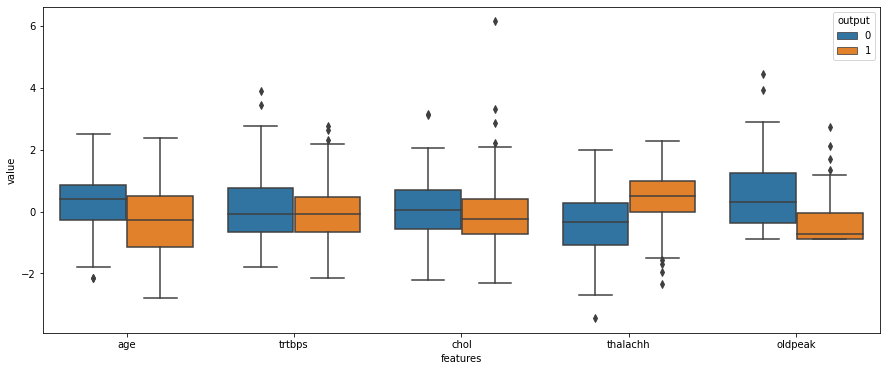

In [177]:
#Box Plot
plt.figure(figsize = (15, 6))
sns.boxplot(x = "features", y = "value", hue = "output", data = data_melted)
plt.show()

### Swarm Plot Analysis<a class="anchor" id="1.11"></a>
[Task 01](#1)

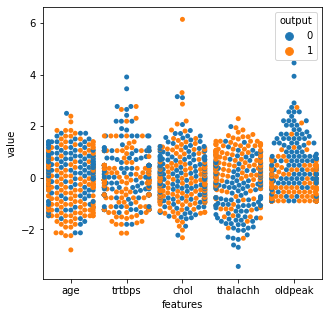

In [178]:
plt.figure(figsize = (5, 5))
sns.swarmplot(x = "features", y = "value", hue = "output", data = data_melted)
plt.show()

### Cat Plot Analysis<a class="anchor" id="1.12"></a>
[Task 01](#1)

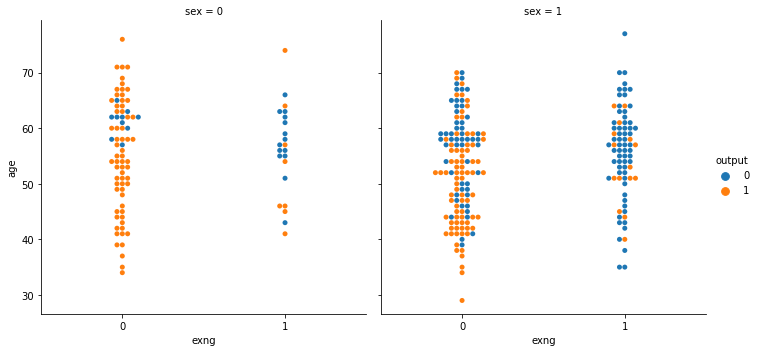

In [179]:
sns.catplot(x = "exng", y = "age", hue = "output", col = "sex", kind = "swarm", data = df)

### Correlation Analysis<a class="anchor" id="1.13"></a>
[Task 01](#1)

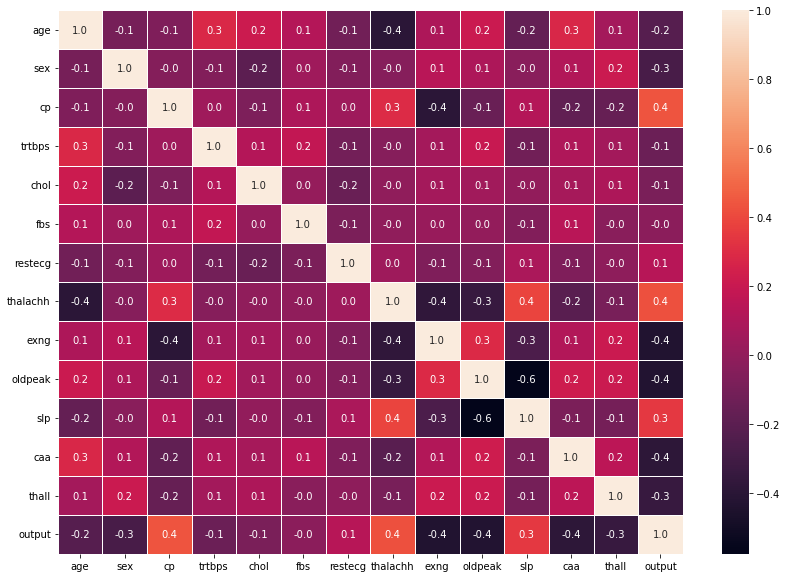

In [180]:
plt.figure(figsize = (14,10))
# sns.heatmap(df.corr(), annot = True, fmt = '.1f', linewidths = 0.5, linecolor = "#fff")
sns.heatmap(df.corr(), annot = True, fmt = '.1f', linewidths = 0.5)
plt.show()

### Outlier Detection<a class="anchor" id="1.14"></a>
[Task 01](#1)

In [181]:
numeric_list = ["age", "trtbps", "chol", "thalachh", "oldpeak"]
df_numeric = df.loc[:, numeric_list]
df_numeric.head()

,age,trtbps,chol,thalachh,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6


In [182]:
#Outlier Detection
for i in numeric_list:
    
    #IQR
    Q1 = np.percentile(df.loc[:, i], 25)
    Q3 = np.percentile(df.loc[:, i], 75)
    
    IQR = Q3 - Q1
    
    print("Old Shape : ", df.loc[:, i].shape)
    
    #Upper Bound
    upper = np.where(df.loc[:, i] >= (Q3 + 1.5 * IQR))
    
    #Lower Bound
    lower = np.where(df.loc[:, i] <= (Q1 - 1.5 * IQR))
    
    print("{} -- {}")
    
    try:
        df.drop(upper[0], inplace = True)
    except: print("KeyErrr : {} not found in axis".format(upper[0]))
        
    try:
        df.drop(lower[0], inplace = True)
    except: print("KeyError: {} not found in axis".format(lower[0]))
    
    print("New Shape : ", df.shape)

Old Shape :  (303,)
{} -- {}
New Shape :  (303, 14)
Old Shape :  (303,)
{} -- {}
New Shape :  (290, 14)
Old Shape :  (290,)
{} -- {}
New Shape :  (285, 14)
Old Shape :  (285,)
{} -- {}
New Shape :  (284, 14)
Old Shape :  (284,)
{} -- {}
KeyErrr : [195 210 211 235 273 276] not found in axis
New Shape :  (284, 14)


In [183]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [184]:
col_names = df.columns.tolist()
print ("Column names:")
print (col_names)

Column names:
['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']


In [185]:
notPatient = df.loc[df['output'] == 0]
patient    = df.loc[df['output'] == 1]

In [186]:
df.shape, notPatient.shape, patient.shape 

((284, 14), (126, 14), (158, 14))

In [187]:
print(notPatient.shape[0]*100/df.shape[0])

44.36619718309859


In [188]:
print(patient.shape[0]*100/df.shape[0])

55.63380281690141


###  Data Imbalancing <a class="anchor" id="1.15"></a>
[Task 01](#1)

In [189]:
df1 = df.copy()
df2 = df.copy()
# splitting dataframe by groups
# grouping by particular dataframe column
 
grouped = df2.groupby(df.output)
df_class_0 = grouped.get_group(0)
df_class_1 = grouped.get_group(1)
df_class_1

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,56,1,1,120,240,0,1,169,0,0.0,0,0,2,1
161,55,0,1,132,342,0,1,166,0,1.2,2,0,2,1
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


#### Low Imbalance dataset (65% and 35%) <a class="anchor" id="1.15.1"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [190]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=84)  # 35 % 84*65/35=156
df_resample_class2 = resample(df_class_1, replace=True, n_samples=156) # 65 %
df_low_imbalance = pd.concat([df_resample_class1, df_resample_class2])

df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_low_imbalance.shape

((126, 14), (158, 14), (84, 14), (156, 14), (240, 14))

#### Medium Imbalance dataset (75% and 25%) <a class="anchor" id="1.15.2"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [191]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=52)  # 25 % 52*75/25=156
df_resample_class2 = resample(df_class_1, replace=True, n_samples=156) # 75 %
df_medium_imbalance = pd.concat([df_resample_class1, df_resample_class2])

df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_medium_imbalance.shape

((126, 14), (158, 14), (52, 14), (156, 14), (208, 14))

#### High Imbalance dataset (90% and 10%) <a class="anchor" id="1.15.3"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [192]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=17)  # 10 % 17*9=153
df_resample_class2 = resample(df_class_1, replace=True, n_samples=153) # 90 %
df_high_imbalance = pd.concat([df_resample_class1, df_resample_class2])

df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_high_imbalance.shape

((126, 14), (158, 14), (17, 14), (153, 14), (170, 14))

In [193]:
# df_new.to_csv("heart_new.csv", index=False)

## Task 02<a class="anchor" id="2"></a>
[Table of Contents](#0)

To establish a baseline, perform stratified cross-validation on each of the datasets and their surrogates and train a random forest. Report baseline results using appropriate metrics.

### Encoding Categorical Column <a class="anchor" id="2.1"></a>
[Task 02](#2)

In [194]:
df_low_imbalance = pd.get_dummies(df_low_imbalance , columns = categorical_list[:-1], drop_first = True)
df_low_imbalance.head()

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,...,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,thall_1,thall_2,thall_3
289,55,128,205,130,2.0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,0,1
293,67,152,212,150,0.8,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
200,44,110,197,177,0.0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
166,67,120,229,129,2.6,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,1
189,41,110,172,158,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [195]:
df_medium_imbalance = pd.get_dummies(df_medium_imbalance , columns = categorical_list[:-1], drop_first = True)
df_medium_imbalance.head()

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,...,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
174,60,130,206,132,2.4,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,1
194,60,140,185,155,3.0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
276,58,146,218,105,2.0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
218,65,135,254,127,2.8,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
174,60,130,206,132,2.4,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,1


In [196]:
df_high_imbalance = pd.get_dummies(df_high_imbalance , columns = categorical_list[:-1], drop_first = True)
df_high_imbalance.head()

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,...,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_2,thall_3
288,57,110,335,143,3.0,0,1,0,0,0,...,0,1,1,0,1,0,0,0,0,1
263,63,108,269,169,1.8,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
238,77,125,304,162,0.0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
182,61,130,330,169,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
242,64,145,212,132,2.0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Declare feature vector and target variable, Normalization and Train - Test Split   <a class="anchor" id="2.2"></a>
[Task 02](#2)

In [197]:
# get datasets
def get_dataset_low():    
    X = df_low_imbalance.drop(["output"], axis = 1)
    y= df_low_imbalance[["output"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y,random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test

def get_dataset_medium():    
    X = df_medium_imbalance.drop(["output"], axis = 1)
    y= df_medium_imbalance[["output"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test

def get_dataset_high():    
    X = df_high_imbalance.drop(["output"], axis = 1)
    y= df_high_imbalance[["output"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test

### Random Forest Classifier <a class="anchor" id="2.3"></a>
[Task 02](#2)

In [198]:
model_parameters = {"Random Forest": {"model": RandomForestClassifier(), 
                                      "params": {"n_estimators": [10, 50, 100], 
                                                 "max_features": ["auto", "sqrt", "log2"], 
                                                 "max_depth": list(range(1, 15, 3))}}
#                     ,
#                    "Decision Tree": {"model": DecisionTreeClassifier(), 
#                                      "params": {"criterion": ["gini", "entropy"], 
#                                                 "max_features": ["auto", "sqrt", "log2"], 
#                                                 "max_depth": list(range(1, 30, 3))}}
                   }

In [199]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_low, X_test_low, y_train_low, y_test_low = get_dataset_low()
for model_name, parameters in model_parameters.items():
    rf_low = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_low.fit(X_train_low, y_train_low)
    y_pred_prob_low = rf_low.predict_proba(X_test_low) 
    y_pred_low = np.argmax(y_pred_prob_low, axis = 1)    
    scores.append([model_name, dict(rf_low.best_params_), rf_low.best_score_, accuracy_score(y_pred_low, y_test_low)])
print("Low Imbalance Dataset")
print(scores)

Low Imbalance Dataset
[['Random Forest', {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 13}, 0.9043290043290042, 0.9583333333333334]]


In [200]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_medium, X_test_medium, y_train_medium, y_test_medium = get_dataset_medium()
for model_name, parameters in model_parameters.items():
    rf_medium = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_medium.fit(X_train_medium, y_train_medium)
    y_pred_prob_medium = rf_medium.predict_proba(X_test_medium) 
    y_pred_medium = np.argmax(y_pred_prob_medium, axis = 1)    
    scores.append([model_name, dict(rf_medium.best_params_), rf_medium.best_score_, accuracy_score(y_pred_medium, y_test_medium)])
print("Medium Imbalance Dataset")
print(scores)

Medium Imbalance Dataset
[['Random Forest', {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10}, 0.9160087719298247, 1.0]]


In [201]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_high, X_test_high, y_train_high, y_test_high = get_dataset_high()
for model_name, parameters in model_parameters.items():
    rf_high = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_high.fit(X_train_high, y_train_high)
    y_pred_prob_high = rf_high.predict_proba(X_test_high) 
    y_pred_high = np.argmax(y_pred_prob_high, axis = 1)    
    scores.append([model_name, dict(rf_high.best_params_), rf_high.best_score_, accuracy_score(y_pred_high, y_test_high)])
print("High Imbalance Dataset")
print(scores)

High Imbalance Dataset
[['Random Forest', {'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 13}, 0.9450000000000001, 0.8823529411764706]]


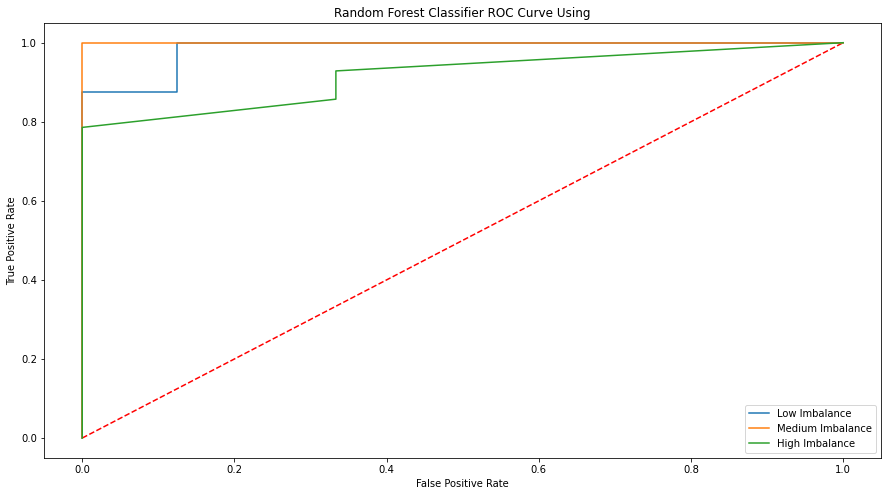

In [202]:
#ROC Curve
fpr_low, tpr_low, thresholds_low = roc_curve(y_test_low, y_pred_prob_low[:, 1])
fpr_medium, tpr_medium, thresholds_medium = roc_curve(y_test_medium, y_pred_prob_medium[:, 1])
fpr_high, tpr_high, thresholds_high = roc_curve(y_test_high, y_pred_prob_high[:, 1])

#Plot Curve
plt.figure(figsize = (15, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr_low, tpr_low, label = "Low Imbalance")
plt.plot(fpr_medium, tpr_medium, label = "Medium Imbalance")
plt.plot(fpr_high, tpr_high, label = "High Imbalance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest Classifier ROC Curve Using")
plt.legend()
# plt.savefig('heart_attack_ROC_Curve_low_medium_high_fig2_correct.png')
# plt.savefig('heart_attack_ROC_Curve_low_medium_high_fig2_correct.png')

plt.show()

In [203]:
# from sklearn.metrics import accuracy_score, roc_curve,  
# from sklearn.metrics import precision_score, confusion_matrix, silhouette_samples, silhouette_score
# from sklearn.metrics import auc, precision_recall_curve,  average_precision_score

### precision_recall_curve

Random Forest (Low Balanced Data): f1=0.970 auc=0.992
Random Forest (Medium Balanced Data): f1=1.000 auc=1.000
Random Forest (High Balanced Data): f1=0.929 auc=0.983


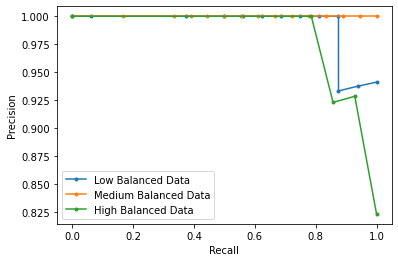

In [204]:
#PR Curve
y_predict_low = rf_low.predict(X_test_low)
y_predict_medium = rf_medium.predict(X_test_medium)
y_predict_high = rf_high.predict(X_test_high)

precision_low, recall_low, _ = precision_recall_curve(y_test_low, y_pred_prob_low[:, 1])
precision_medium, recall_medium, _ = precision_recall_curve(y_test_medium, y_pred_prob_medium[:, 1])
precision_high, recall_high, _ = precision_recall_curve(y_test_high, y_pred_prob_high[:, 1])

f1_low, auc_low = f1_score(y_test_low, y_predict_low), auc(recall_low, precision_low)
f1_medium, auc_medium = f1_score(y_test_medium, y_predict_medium), auc(recall_medium, precision_medium)
f1_high, auc_high = f1_score(y_test_high, y_predict_high), auc(recall_high, precision_high)

# summarize scores
print('Random Forest (Low Balanced Data): f1=%.3f auc=%.3f' % (f1_low, auc_low))
print('Random Forest (Medium Balanced Data): f1=%.3f auc=%.3f' % (f1_medium, auc_medium))
print('Random Forest (High Balanced Data): f1=%.3f auc=%.3f' % (f1_high, auc_high))

# plot the precision-recall curves
plt.plot(recall_low, precision_low, marker='.', label='Low Balanced Data')
plt.plot(recall_medium, precision_medium, marker='.', label='Medium Balanced Data')
plt.plot(recall_high, precision_high, marker='.', label='High Balanced Data')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Precision Score

In [205]:
final_results_low = []
confusion_matrix_list_low = []
    
score_low = precision_score(y_test_low, y_predict_low)
cm_low = confusion_matrix(y_test_low, y_predict_low)

final_results_low.append((score_low))
confusion_matrix_list_low.append((cm_low))

final_results_low

[0.9411764705882353]

In [206]:
final_results_medium = []
confusion_matrix_list_medium = []
    
score_medium = precision_score(y_test_medium, y_predict_medium)
cm_medium = confusion_matrix(y_test_medium, y_predict_medium)

final_results_medium.append((score_medium))
confusion_matrix_list_medium.append((cm_medium))

final_results_medium

[1.0]

In [207]:
final_results_high = []
confusion_matrix_list_high = []

score_high = precision_score(y_test_high, y_predict_high)
cm_high = confusion_matrix(y_test_high, y_predict_high)

final_results_high.append((score_high))
confusion_matrix_list_high.append((cm_high))

final_results_high

[0.9285714285714286]

### Confusion Matrix

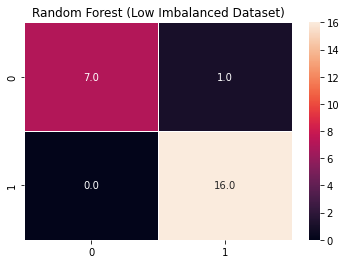

In [208]:
for i in confusion_matrix_list_low:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (Low Imbalanced Dataset)")
    plt.show()

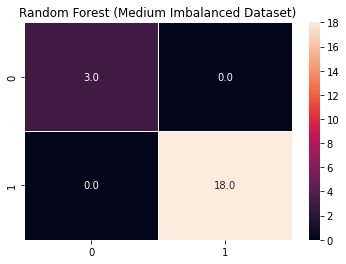

In [209]:
for i in confusion_matrix_list_medium:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (Medium Imbalanced Dataset)")
    plt.show()

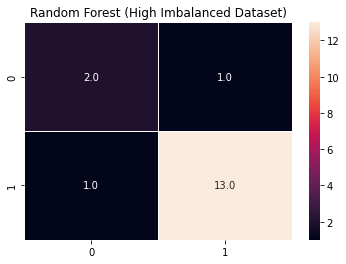

In [210]:
for i in confusion_matrix_list_high:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (High Imbalanced Dataset)")
    plt.show()

In [211]:
models = {}
# Random Forest
models['Random Forest'] = RandomForestClassifier()

In [228]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_low, y_train_low)    
    # Prediction 
    predictions = models[key].predict(X_test_low)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_low)
    MAE[key] = mean_absolute_error(predictions, y_test_low)
    R_Squared_score[key] = r2_score(predictions, y_test_low)
    RMSE[key] = mean_squared_error(predictions, y_test_low, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_low)

In [229]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()
df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.041667,0.041667,0.798319,0.204124,0.958333


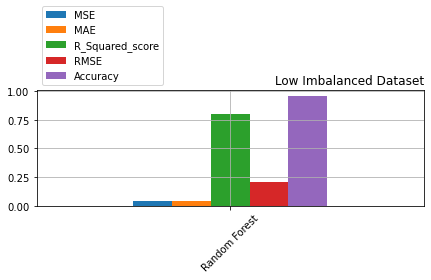

In [230]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.grid()
plt.title("Low Imbalanced Dataset", loc="right")
plt.tight_layout()

plt.savefig('fig4_heart_attack_Metrics_Curve_low_medium_high.png')
plt.savefig('fig4_heart_attack_Metrics_Curve_low_medium_high.pdf')

In [231]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_medium, y_train_medium)    
    # Prediction 
    predictions = models[key].predict(X_test_medium)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_medium)
    MAE[key] = mean_absolute_error(predictions, y_test_medium)
    R_Squared_score[key] = r2_score(predictions, y_test_medium)
    RMSE[key] = mean_squared_error(predictions, y_test_medium, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_medium)

In [232]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()
df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.047619,0.047619,0.691176,0.218218,0.952381


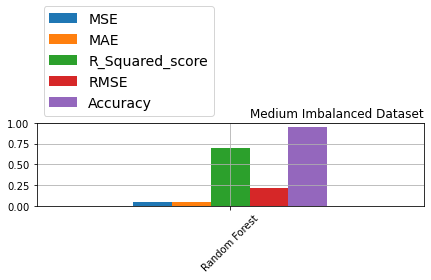

In [233]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.grid()
plt.title("Medium Imbalanced Dataset", loc="right")
plt.tight_layout()
plt.savefig('fig5_heart_attack_Metrics_medium.png')
plt.savefig('fig5_heart_attack_Metrics_medium.pdf')

In [238]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_high, y_train_high)    
    # Prediction 
    predictions = models[key].predict(X_test_high)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_high)
    MAE[key] = mean_absolute_error(predictions, y_test_high)
    R_Squared_score[key] = r2_score(predictions, y_test_high)
    RMSE[key] = mean_squared_error(predictions, y_test_high, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_high)

In [239]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()
df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.117647,0.117647,-1.125,0.342997,0.882353


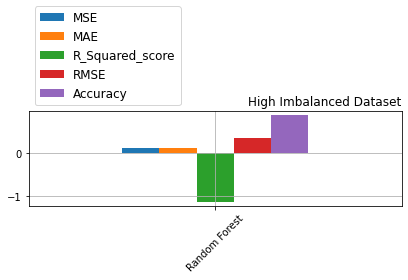

In [252]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 12})
plt.grid()
plt.title("High Imbalanced Dataset", loc="right")
# plt.figure(figsize=(20, 24))


plt.tight_layout()
plt.savefig('1fig6_heart_attack_Metrics_high.png')
plt.savefig('1fig6_heart_attack_Metrics_high.pdf')


##  Task 03 <a class="anchor" id="3"></a>
[Table of Contents](#0)

Create 10 stratified folds (to ensure the imbalance ratio remains the same in each fold) for each of the datasets.

### Stratified 10 Folds <a class="anchor" id="3.1"></a>
[Task 03](#3)

In [115]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]

In [116]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]

In [117]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]

##  Task 04 <a class="anchor" id="4"></a>
[Table of Contents](#0)

4. Using the data of 9 of these folds:
    1. Using the Elbow method and the Silhouette method, identify the number of clusters in the dataset.There should be some level of agreement between these indices (or at least you should be able to identify lower and upper bounds).

### Optimal number of clusters<a class="anchor" id="4.1"></a>
[Task 04](#4)

####  Silhouette analysis to find optimal number of clusters<a class="anchor" id="4.1.1"></a>
[Task 04](#4)

[Optimal number of clusters](#4.1)

In [118]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_low
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

Low Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.20252782979756398
For n_clusters = 3 The average silhouette_score is : 0.17859819094973095
For n_clusters = 4 The average silhouette_score is : 0.19891129597532714
For n_clusters = 5 The average silhouette_score is : 0.1811036542532827
For n_clusters = 6 The average silhouette_score is : 0.1920948077769085
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.1949046576029672
For n_clusters = 3 The average silhouette_score is : 0.16782020112530321
For n_clusters = 4 The average silhouette_score is : 0.19277252391424635
For n_clusters = 5 The average silhouette_score is : 0.1709914696704869
For n_clusters = 6 The average silhouette_score is : 0.1654833681178141
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.20344654594530387
For n_clusters = 3 The average silhouette_score is : 0.16973901998817462
For n_clusters = 4 The average silhouette_score is : 0.1927742964167178
For n_clust

In [119]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_medium
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

Medium Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.1947978513730612
For n_clusters = 3 The average silhouette_score is : 0.18527827186777246
For n_clusters = 4 The average silhouette_score is : 0.15216390604082092
For n_clusters = 5 The average silhouette_score is : 0.17672884702390443
For n_clusters = 6 The average silhouette_score is : 0.19044753491133443
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.1910284342332885
For n_clusters = 3 The average silhouette_score is : 0.1730554952555177
For n_clusters = 4 The average silhouette_score is : 0.18501494759791443
For n_clusters = 5 The average silhouette_score is : 0.1789501185703101
For n_clusters = 6 The average silhouette_score is : 0.1708538086329337
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.19659895963175014
For n_clusters = 3 The average silhouette_score is : 0.1890546144762446
For n_clusters = 4 The average silhouette_score is : 0.19179706465375274
For n_cl

In [120]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_high
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

High Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.19608457589755982
For n_clusters = 3 The average silhouette_score is : 0.18747817999744035
For n_clusters = 4 The average silhouette_score is : 0.1992877229064567
For n_clusters = 5 The average silhouette_score is : 0.19362231247118708
For n_clusters = 6 The average silhouette_score is : 0.19423046724769272
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.19402017895937282
For n_clusters = 3 The average silhouette_score is : 0.1878858843992728
For n_clusters = 4 The average silhouette_score is : 0.1781106080510324
For n_clusters = 5 The average silhouette_score is : 0.18090707701862252
For n_clusters = 6 The average silhouette_score is : 0.1860578362486405
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.2041049149504251
For n_clusters = 3 The average silhouette_score is : 0.1972075266236154
For n_clusters = 4 The average silhouette_score is : 0.18889328914571255
For n_clus

#### Elbow method to find optimal number of clusters<a class="anchor" id="4.1.2"></a>
[Task 04](#4)

[Optimal number of clusters](#4.1)

Low Imbalance Dataset
Fold: 1


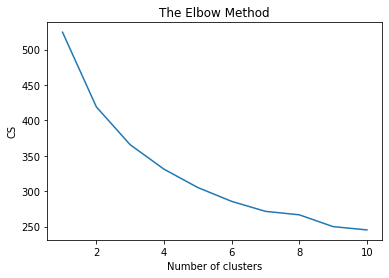

Fold: 2


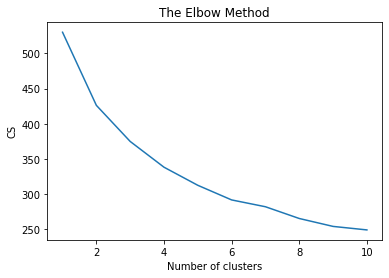

Fold: 3


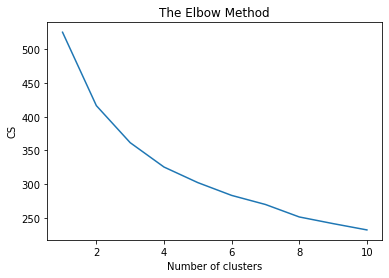

Fold: 4


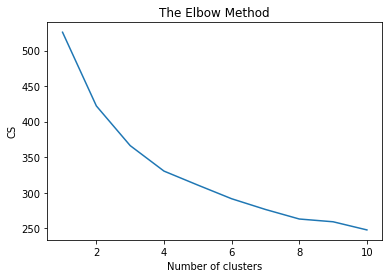

Fold: 5


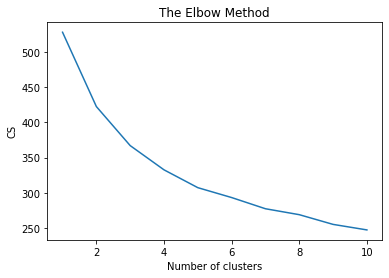

Fold: 6


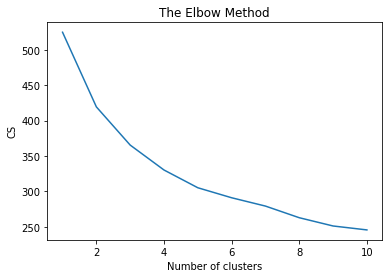

Fold: 7


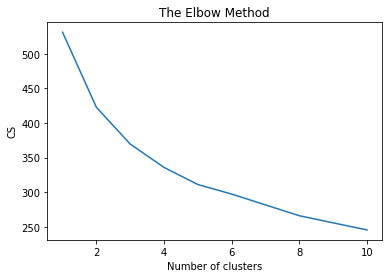

Fold: 8


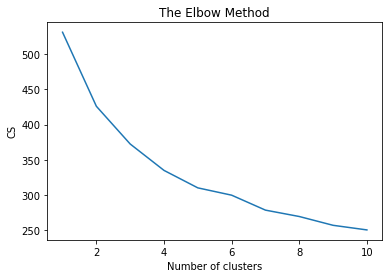

Fold: 9


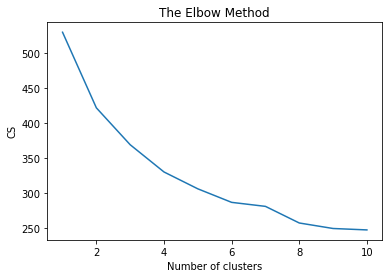

In [121]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans_low = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans_low.fit(X_train_low)
            cs.append(kmeans_low.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

Medium Imbalance Dataset
Fold: 1


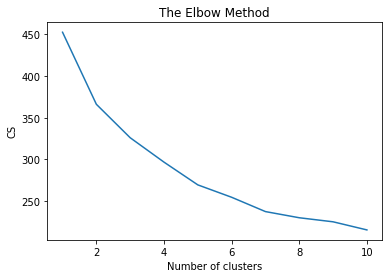

Fold: 2


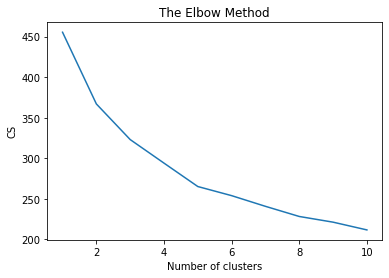

Fold: 3


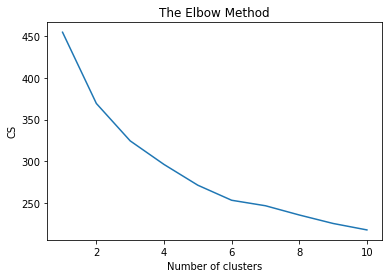

Fold: 4


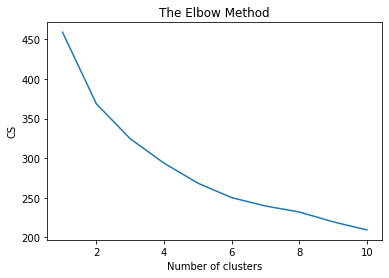

Fold: 5


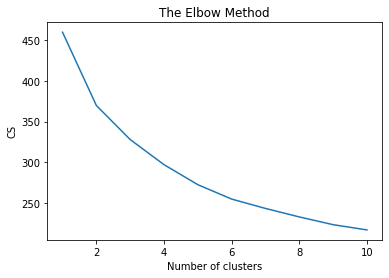

Fold: 6


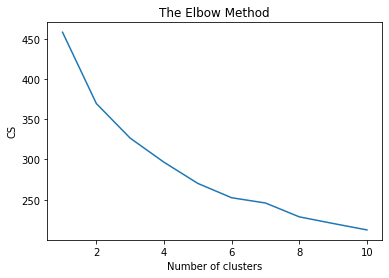

Fold: 7


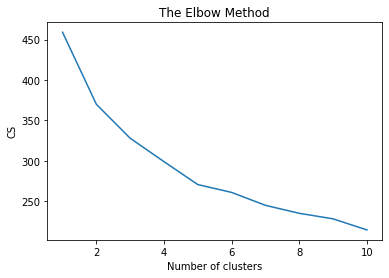

Fold: 8


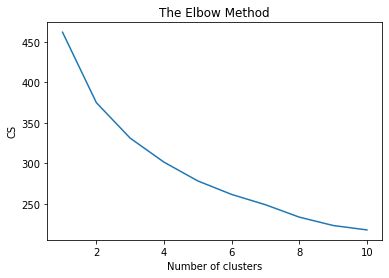

Fold: 9


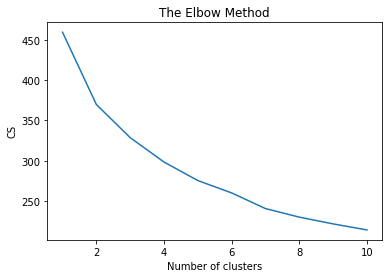

In [122]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans_medium = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans_medium.fit(X_train_medium)
            cs.append(kmeans_medium.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

In [ ]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans_high = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans_high.fit(X_train_high)
            cs.append(kmeans_high.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

### KMeans Cluster (n_clusters = 2)<a class="anchor" id="4.2"></a>
[Task 04](#4)
    
    B. Run k-means in the data set using the identified number of clusters. Select as final clustering that with the lowest output criteria.

Low Imbalance Dataset
KFOLD:  1
Ideal: 0.531
> folds=2, accuracy=0.253 (0.196,0.309)
> folds=3, accuracy=0.368 (0.169,0.703)
> folds=4, accuracy=0.605 (0.122,0.792)
> folds=5, accuracy=0.794 (0.667,0.846)
> folds=6, accuracy=0.503 (0.156,0.906)
> folds=7, accuracy=0.467 (0.143,0.852)
> folds=8, accuracy=0.399 (0.042,0.833)
> folds=9, accuracy=0.398 (0.136,0.864)
> folds=10, accuracy=0.660 (0.053,0.947)


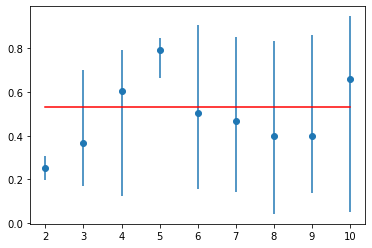

KFOLD:  2
Ideal: 0.536
> folds=2, accuracy=0.206 (0.144,0.268)
> folds=3, accuracy=0.637 (0.266,0.831)
> folds=4, accuracy=0.559 (0.229,0.857)
> folds=5, accuracy=0.668 (0.184,0.872)
> folds=6, accuracy=0.523 (0.062,0.848)
> folds=7, accuracy=0.523 (0.143,0.821)
> folds=8, accuracy=0.521 (0.160,0.917)
> folds=9, accuracy=0.629 (0.143,0.909)
> folds=10, accuracy=0.426 (0.100,1.000)


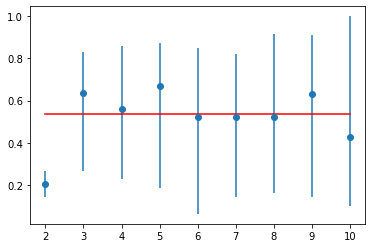

KFOLD:  3
Ideal: 0.428
> folds=2, accuracy=0.454 (0.196,0.711)
> folds=3, accuracy=0.593 (0.231,0.846)
> folds=4, accuracy=0.487 (0.184,0.792)
> folds=5, accuracy=0.319 (0.128,0.769)
> folds=6, accuracy=0.676 (0.303,0.875)
> folds=7, accuracy=0.593 (0.143,0.857)
> folds=8, accuracy=0.611 (0.208,0.875)
> folds=9, accuracy=0.440 (0.095,0.864)
> folds=10, accuracy=0.585 (0.200,0.947)


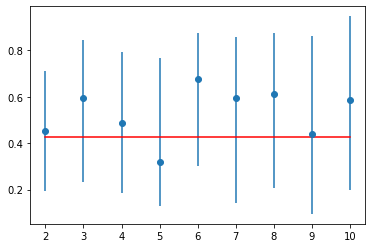

KFOLD:  4
Ideal: 0.495
> folds=2, accuracy=0.443 (0.134,0.753)
> folds=3, accuracy=0.758 (0.692,0.844)
> folds=4, accuracy=0.427 (0.104,0.714)
> folds=5, accuracy=0.556 (0.179,0.795)
> folds=6, accuracy=0.619 (0.281,0.938)
> folds=7, accuracy=0.528 (0.143,0.857)
> folds=8, accuracy=0.753 (0.583,0.917)
> folds=9, accuracy=0.517 (0.190,0.909)
> folds=10, accuracy=0.523 (0.053,0.842)


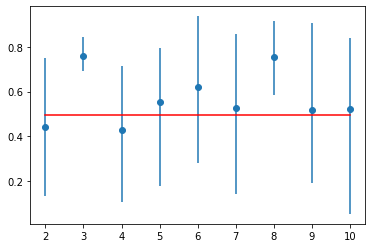

KFOLD:  5
Ideal: 0.567
> folds=2, accuracy=0.428 (0.134,0.722)
> folds=3, accuracy=0.783 (0.723,0.862)
> folds=4, accuracy=0.485 (0.122,0.816)
> folds=5, accuracy=0.181 (0.103,0.237)
> folds=6, accuracy=0.380 (0.094,0.848)
> folds=7, accuracy=0.625 (0.143,0.929)
> folds=8, accuracy=0.406 (0.083,0.875)
> folds=9, accuracy=0.644 (0.190,0.909)
> folds=10, accuracy=0.408 (0.100,0.947)


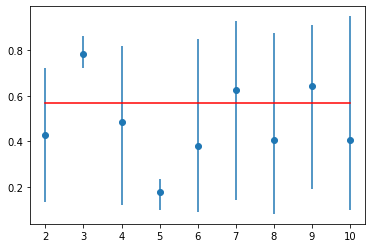

KFOLD:  6
Ideal: 0.510
> folds=2, accuracy=0.263 (0.186,0.340)
> folds=3, accuracy=0.411 (0.172,0.754)
> folds=4, accuracy=0.466 (0.167,0.857)
> folds=5, accuracy=0.496 (0.154,0.816)
> folds=6, accuracy=0.625 (0.182,0.909)
> folds=7, accuracy=0.379 (0.036,0.926)
> folds=8, accuracy=0.467 (0.040,0.958)
> folds=9, accuracy=0.465 (0.048,0.955)
> folds=10, accuracy=0.615 (0.053,0.950)


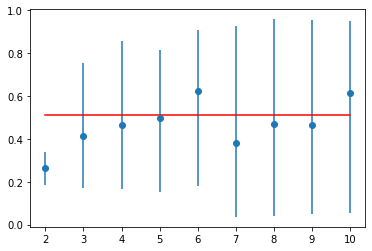

KFOLD:  7
Ideal: 0.544
> folds=2, accuracy=0.810 (0.794,0.827)
> folds=3, accuracy=0.446 (0.215,0.846)
> folds=4, accuracy=0.400 (0.163,0.837)
> folds=5, accuracy=0.472 (0.128,0.718)
> folds=6, accuracy=0.605 (0.152,0.906)
> folds=7, accuracy=0.647 (0.179,0.889)
> folds=8, accuracy=0.659 (0.167,0.880)
> folds=9, accuracy=0.529 (0.136,0.909)
> folds=10, accuracy=0.538 (0.105,0.900)


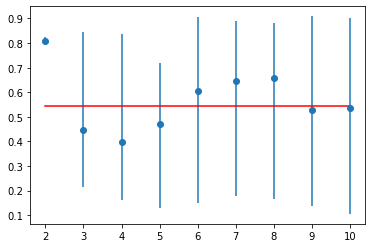

KFOLD:  8
Ideal: 0.569
> folds=2, accuracy=0.563 (0.299,0.827)
> folds=3, accuracy=0.656 (0.277,0.877)
> folds=4, accuracy=0.647 (0.184,0.857)
> folds=5, accuracy=0.544 (0.128,0.872)
> folds=6, accuracy=0.578 (0.125,0.906)
> folds=7, accuracy=0.572 (0.148,0.893)
> folds=8, accuracy=0.397 (0.083,0.875)
> folds=9, accuracy=0.417 (0.091,0.909)
> folds=10, accuracy=0.422 (0.050,0.800)


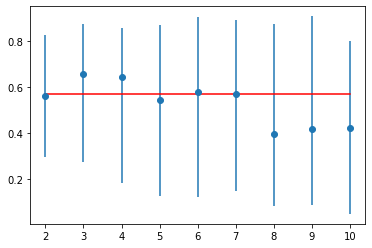

KFOLD:  9
Ideal: 0.492
> folds=2, accuracy=0.759 (0.735,0.784)
> folds=3, accuracy=0.421 (0.185,0.738)
> folds=4, accuracy=0.616 (0.224,0.878)
> folds=5, accuracy=0.533 (0.179,0.897)
> folds=6, accuracy=0.435 (0.061,0.727)
> folds=7, accuracy=0.564 (0.071,0.857)
> folds=8, accuracy=0.383 (0.080,0.792)
> folds=9, accuracy=0.505 (0.182,0.909)
> folds=10, accuracy=0.550 (0.100,0.900)


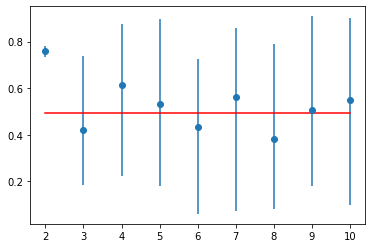

KFOLD:  10


In [124]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_low, y_train_low, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _ = evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

Medium Imbalance Dataset
KFOLD:  1
Ideal: 0.452
> folds=2, accuracy=0.417 (0.190,0.643)
> folds=3, accuracy=0.542 (0.232,0.768)
> folds=4, accuracy=0.560 (0.262,0.905)
> folds=5, accuracy=0.370 (0.121,0.727)
> folds=6, accuracy=0.524 (0.214,0.929)
> folds=7, accuracy=0.494 (0.167,0.792)
> folds=8, accuracy=0.583 (0.095,0.952)
> folds=9, accuracy=0.326 (0.105,0.842)
> folds=10, accuracy=0.406 (0.059,0.812)


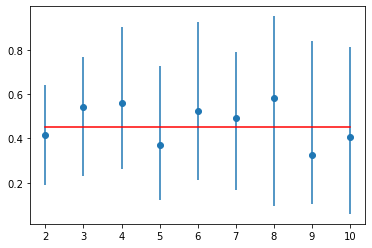

KFOLD:  2
Ideal: 0.482
> folds=2, accuracy=0.774 (0.750,0.798)
> folds=3, accuracy=0.762 (0.750,0.768)
> folds=4, accuracy=0.381 (0.214,0.810)
> folds=5, accuracy=0.428 (0.152,0.824)
> folds=6, accuracy=0.292 (0.071,0.607)
> folds=7, accuracy=0.363 (0.125,0.708)
> folds=8, accuracy=0.589 (0.190,0.905)
> folds=9, accuracy=0.553 (0.111,0.842)
> folds=10, accuracy=0.441 (0.062,0.875)


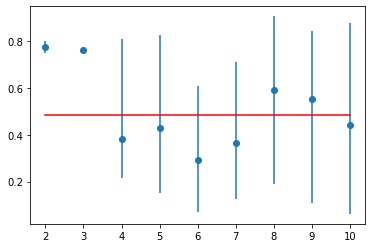

KFOLD:  3
Ideal: 0.506
> folds=2, accuracy=0.560 (0.393,0.726)
> folds=3, accuracy=0.393 (0.232,0.679)
> folds=4, accuracy=0.440 (0.262,0.667)
> folds=5, accuracy=0.615 (0.382,0.818)
> folds=6, accuracy=0.619 (0.286,0.821)
> folds=7, accuracy=0.393 (0.167,0.583)
> folds=8, accuracy=0.625 (0.333,0.857)
> folds=9, accuracy=0.542 (0.167,0.833)
> folds=10, accuracy=0.523 (0.188,0.824)


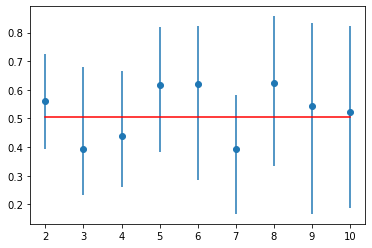

KFOLD:  4
Ideal: 0.476
> folds=2, accuracy=0.768 (0.738,0.798)
> folds=3, accuracy=0.619 (0.321,0.786)
> folds=4, accuracy=0.363 (0.167,0.786)
> folds=5, accuracy=0.559 (0.212,0.788)
> folds=6, accuracy=0.339 (0.143,0.750)
> folds=7, accuracy=0.417 (0.083,0.833)
> folds=8, accuracy=0.411 (0.190,0.905)
> folds=9, accuracy=0.378 (0.111,0.895)
> folds=10, accuracy=0.553 (0.176,0.941)


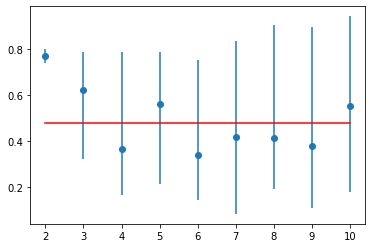

KFOLD:  5
Ideal: 0.589
> folds=2, accuracy=0.738 (0.714,0.762)
> folds=3, accuracy=0.411 (0.214,0.714)
> folds=4, accuracy=0.500 (0.214,0.738)
> folds=5, accuracy=0.662 (0.265,0.824)
> folds=6, accuracy=0.315 (0.179,0.750)
> folds=7, accuracy=0.530 (0.125,0.792)
> folds=8, accuracy=0.560 (0.095,0.810)
> folds=9, accuracy=0.360 (0.053,0.842)
> folds=10, accuracy=0.523 (0.176,0.941)


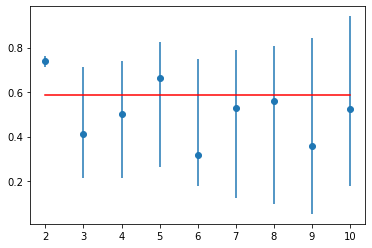

KFOLD:  6
Ideal: 0.494
> folds=2, accuracy=0.262 (0.262,0.262)
> folds=3, accuracy=0.381 (0.143,0.768)
> folds=4, accuracy=0.464 (0.119,0.738)
> folds=5, accuracy=0.392 (0.118,0.912)
> folds=6, accuracy=0.310 (0.036,0.786)
> folds=7, accuracy=0.655 (0.167,0.958)
> folds=8, accuracy=0.482 (0.048,0.857)
> folds=9, accuracy=0.611 (0.263,0.947)
> folds=10, accuracy=0.626 (0.176,0.941)


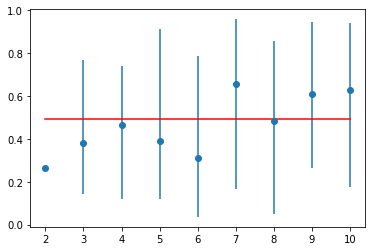

KFOLD:  7
Ideal: 0.530
> folds=2, accuracy=0.518 (0.298,0.738)
> folds=3, accuracy=0.435 (0.250,0.768)
> folds=4, accuracy=0.387 (0.190,0.762)
> folds=5, accuracy=0.407 (0.206,0.879)
> folds=6, accuracy=0.500 (0.143,0.821)
> folds=7, accuracy=0.333 (0.125,0.792)
> folds=8, accuracy=0.530 (0.190,0.857)
> folds=9, accuracy=0.496 (0.056,0.842)
> folds=10, accuracy=0.422 (0.118,0.941)


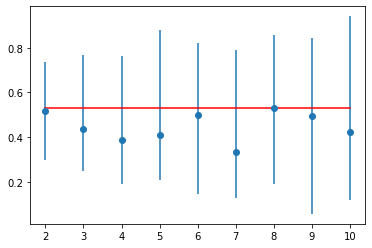

KFOLD:  8
Ideal: 0.521
> folds=2, accuracy=0.534 (0.329,0.738)
> folds=3, accuracy=0.561 (0.286,0.714)
> folds=4, accuracy=0.611 (0.279,0.786)
> folds=5, accuracy=0.472 (0.206,0.735)
> folds=6, accuracy=0.638 (0.250,0.793)
> folds=7, accuracy=0.511 (0.200,0.833)
> folds=8, accuracy=0.472 (0.190,0.773)
> folds=9, accuracy=0.623 (0.211,0.842)
> folds=10, accuracy=0.592 (0.235,0.882)


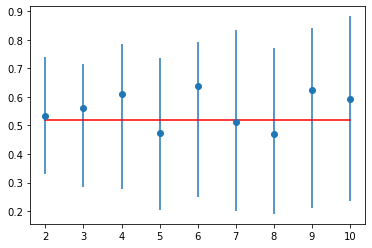

KFOLD:  9
Ideal: 0.408
> folds=2, accuracy=0.493 (0.259,0.726)
> folds=3, accuracy=0.585 (0.268,0.772)
> folds=4, accuracy=0.507 (0.190,0.791)
> folds=5, accuracy=0.331 (0.206,0.706)
> folds=6, accuracy=0.493 (0.207,0.786)
> folds=7, accuracy=0.656 (0.250,0.800)
> folds=8, accuracy=0.392 (0.143,0.762)
> folds=9, accuracy=0.539 (0.211,0.889)
> folds=10, accuracy=0.436 (0.176,0.824)


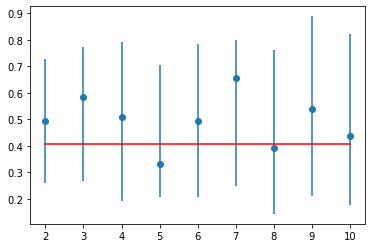

KFOLD:  10


In [125]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_medium, y_train_medium, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _ = evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

High Imbalance Dataset
KFOLD:  1
Ideal: 0.482
> folds=2, accuracy=0.299 (0.290,0.309)
> folds=3, accuracy=0.592 (0.326,0.739)
> folds=4, accuracy=0.495 (0.265,0.714)
> folds=5, accuracy=0.540 (0.222,0.714)
> folds=6, accuracy=0.407 (0.217,0.696)
> folds=7, accuracy=0.627 (0.316,0.800)
> folds=8, accuracy=0.374 (0.118,0.706)
> folds=9, accuracy=0.488 (0.200,0.812)
> folds=10, accuracy=0.445 (0.143,0.857)


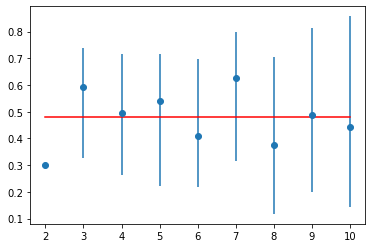

KFOLD:  2
Ideal: 0.482
> folds=2, accuracy=0.502 (0.309,0.696)
> folds=3, accuracy=0.563 (0.326,0.689)
> folds=4, accuracy=0.468 (0.265,0.676)
> folds=5, accuracy=0.526 (0.286,0.704)
> folds=6, accuracy=0.614 (0.304,0.696)
> folds=7, accuracy=0.453 (0.200,0.737)
> folds=8, accuracy=0.480 (0.235,0.778)
> folds=9, accuracy=0.379 (0.188,0.625)
> folds=10, accuracy=0.507 (0.214,0.769)


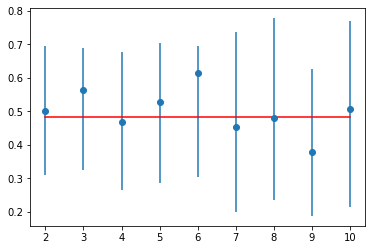

KFOLD:  3
Ideal: 0.511
> folds=2, accuracy=0.498 (0.319,0.676)
> folds=3, accuracy=0.447 (0.283,0.689)
> folds=4, accuracy=0.531 (0.324,0.743)
> folds=5, accuracy=0.557 (0.179,0.741)
> folds=6, accuracy=0.467 (0.261,0.783)
> folds=7, accuracy=0.532 (0.158,0.800)
> folds=8, accuracy=0.531 (0.294,0.778)
> folds=9, accuracy=0.526 (0.250,0.750)
> folds=10, accuracy=0.457 (0.154,0.929)


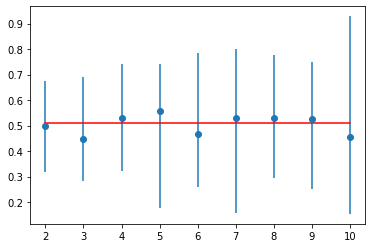

KFOLD:  4
Ideal: 0.558
> folds=2, accuracy=0.543 (0.319,0.768)
> folds=3, accuracy=0.377 (0.196,0.652)
> folds=4, accuracy=0.594 (0.343,0.857)
> folds=5, accuracy=0.283 (0.179,0.333)
> folds=6, accuracy=0.572 (0.217,0.826)
> folds=7, accuracy=0.378 (0.100,0.700)
> folds=8, accuracy=0.477 (0.118,0.889)
> folds=9, accuracy=0.440 (0.125,0.812)
> folds=10, accuracy=0.480 (0.214,0.929)


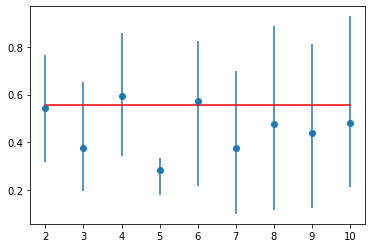

KFOLD:  5
Ideal: 0.500
> folds=2, accuracy=0.304 (0.290,0.319)
> folds=3, accuracy=0.413 (0.261,0.652)
> folds=4, accuracy=0.415 (0.257,0.706)
> folds=5, accuracy=0.390 (0.179,0.714)
> folds=6, accuracy=0.529 (0.174,0.739)
> folds=7, accuracy=0.398 (0.100,0.650)
> folds=8, accuracy=0.562 (0.294,1.000)
> folds=9, accuracy=0.497 (0.000,0.733)
> folds=10, accuracy=0.422 (0.000,0.786)


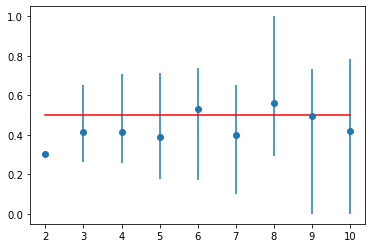

KFOLD:  6
Ideal: 0.500
> folds=2, accuracy=0.703 (0.652,0.754)
> folds=3, accuracy=0.478 (0.304,0.761)
> folds=4, accuracy=0.563 (0.353,0.743)
> folds=5, accuracy=0.448 (0.179,0.750)
> folds=6, accuracy=0.601 (0.217,0.739)
> folds=7, accuracy=0.455 (0.200,0.850)
> folds=8, accuracy=0.428 (0.167,0.765)
> folds=9, accuracy=0.460 (0.067,0.812)
> folds=10, accuracy=0.530 (0.214,0.857)


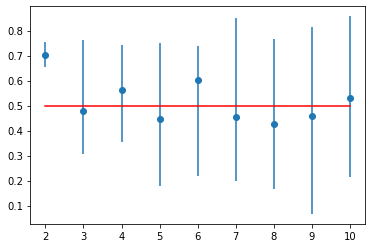

KFOLD:  7
Ideal: 0.449
> folds=2, accuracy=0.710 (0.696,0.725)
> folds=3, accuracy=0.406 (0.217,0.674)
> folds=4, accuracy=0.504 (0.294,0.829)
> folds=5, accuracy=0.560 (0.143,0.741)
> folds=6, accuracy=0.486 (0.087,0.739)
> folds=7, accuracy=0.591 (0.105,0.950)
> folds=8, accuracy=0.498 (0.235,0.944)
> folds=9, accuracy=0.394 (0.062,0.733)
> folds=10, accuracy=0.469 (0.071,0.786)


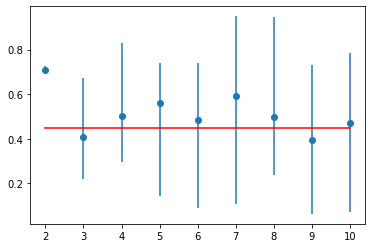

KFOLD:  8
Ideal: 0.507
> folds=2, accuracy=0.464 (0.275,0.652)
> folds=3, accuracy=0.435 (0.261,0.674)
> folds=4, accuracy=0.452 (0.200,0.647)
> folds=5, accuracy=0.500 (0.321,0.821)
> folds=6, accuracy=0.558 (0.130,0.696)
> folds=7, accuracy=0.573 (0.150,0.750)
> folds=8, accuracy=0.424 (0.167,0.706)
> folds=9, accuracy=0.523 (0.188,0.812)
> folds=10, accuracy=0.471 (0.143,0.786)


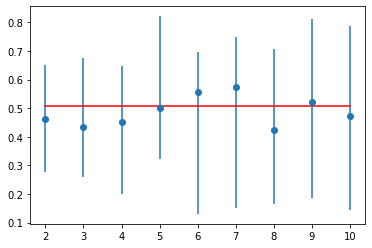

KFOLD:  9
Ideal: 0.558
> folds=2, accuracy=0.312 (0.275,0.348)
> folds=3, accuracy=0.428 (0.283,0.674)
> folds=4, accuracy=0.311 (0.235,0.429)
> folds=5, accuracy=0.442 (0.185,0.704)
> folds=6, accuracy=0.507 (0.217,0.826)
> folds=7, accuracy=0.467 (0.150,0.895)
> folds=8, accuracy=0.534 (0.118,0.833)
> folds=9, accuracy=0.541 (0.067,0.875)
> folds=10, accuracy=0.483 (0.154,0.857)


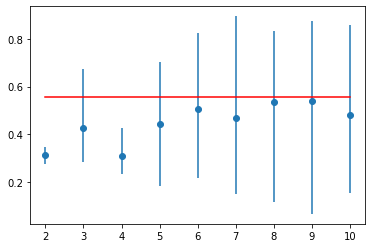

KFOLD:  10


In [126]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_high, y_train_high, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _= evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

### For each cluster, identify its centroid<a class="anchor" id="4.3"></a>
    C. For each cluster, identify its centroid and the number of samples of the minority class in that cluster (as per their labels). Save this information.
[Task 04](#4)

[[ 6.04444444e-01  5.64349376e-01  2.65860865e-01  5.42613381e-01
   3.21470588e-01  9.05882353e-01  1.17647059e-01  1.52941176e-01
   8.23529412e-02  1.52941176e-01  4.11764706e-01  4.94117647e-01
   5.88235294e-01  3.17647059e-01  3.17647059e-01  1.76470588e-01
   7.05882353e-02 -8.67361738e-18  1.41176471e-01  5.88235294e-02
   7.76470588e-01]
 [ 5.35877863e-01  5.24404349e-01  2.70957510e-01  6.64821397e-01
   1.49618321e-01  4.35114504e-01  2.74809160e-01  3.81679389e-01
   9.16030534e-02  1.52671756e-01  5.34351145e-01  6.87022901e-02
   3.05343511e-01  6.56488550e-01  1.29770992e-01  5.34351145e-02
   6.93889390e-17  1.52671756e-02  1.38777878e-16  9.92366412e-01
   7.63358779e-03]]
[0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1
 

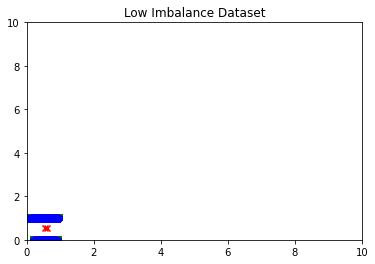

In [127]:
X_train_low, X_test_low, y_train_low, y_test_low = get_dataset_low()
model_low = KMeans(n_clusters=2)
model_low.fit(X_train_low)
centroids = model_low.cluster_centers_

print(centroids)
print(model_low.labels_)
print (Counter(model_low.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_low.labels_):
    plt.scatter(X_train_low.iloc[: , 0], y_train_low['output'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("Low Imbalance Dataset")
plt.show()

[[ 5.82812500e-01  5.43392857e-01  3.85094502e-01  4.70312500e-01
   3.38690476e-01  7.00000000e-01  1.00000000e-01  2.87500000e-01
   1.00000000e-01  1.37500000e-01  4.62500000e-01  1.25000000e-02
   3.37500000e-01  9.00000000e-01  2.50000000e-02  2.25000000e-01
   1.12500000e-01  1.00000000e-01 -1.38777878e-17  1.12500000e-01
   4.12500000e-01  4.50000000e-01]
 [ 4.73130841e-01  4.84245661e-01  3.87673829e-01  6.46862483e-01
   9.45705385e-02  6.26168224e-01  2.89719626e-01  4.48598131e-01
   3.73831776e-02  1.49532710e-01  6.63551402e-01 -9.54097912e-18
   1.02803738e-01 -1.11022302e-16  9.43925234e-01  1.96261682e-01
   8.41121495e-02  1.86915888e-02  1.86915888e-02  9.34579439e-03
   7.66355140e-01  1.96261682e-01]]
[0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1
 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0
 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1
 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1

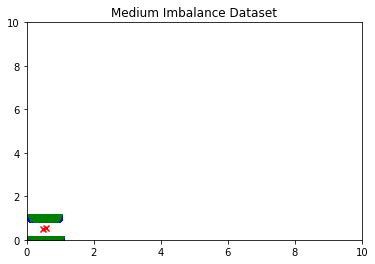

In [128]:
X_train_medium, X_test_medium, y_train_medium, y_test_medium = get_dataset_medium()
model_medium = KMeans(n_clusters=2)
model_medium.fit(X_train_medium)
centroids = model_medium.cluster_centers_

print(centroids)
print(model_medium.labels_)
print (Counter(model_medium.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_medium.labels_):
    plt.scatter(X_train_medium.iloc[: , 0], y_train_medium['output'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("Medium Imbalance Dataset")
plt.show()

[[ 4.75934460e-01  5.03258390e-01  2.50794377e-01  6.67681071e-01
   8.09281268e-02  5.48387097e-01  3.54838710e-01  4.19354839e-01
   5.37634409e-02  1.07526882e-01  6.45161290e-01  2.42861287e-17
   1.18279570e-01  4.44089210e-16  9.46236559e-01  2.15053763e-01
   7.52688172e-02  1.07526882e-02  2.15053763e-02  2.08166817e-17
   8.81720430e-01  9.67741935e-02]
 [ 5.00000000e-01  4.96717172e-01  2.38888889e-01  5.63050314e-01
   2.90789474e-01  4.83333333e-01  2.16666667e-01  3.83333333e-01
   1.00000000e-01  3.33333333e-02  5.83333333e-01  3.33333333e-02
   3.33333333e-01  9.16666667e-01 -4.44089210e-16  1.16666667e-01
   6.66666667e-02  1.66666667e-02  1.66666667e-02  5.00000000e-02
   6.16666667e-01  3.33333333e-01]]
[0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0
 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0

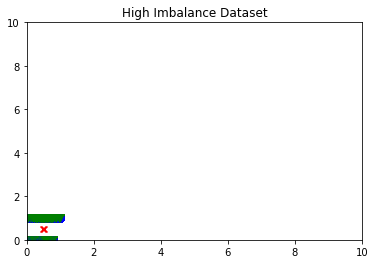

In [129]:
X_train_high, X_test_high, y_train_high, y_test_high = get_dataset_high()
model_high = KMeans(n_clusters=2)
model_high.fit(X_train_high)
centroids = model_high.cluster_centers_

print(centroids)
print(model_high.labels_)
print (Counter(model_high.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_high.labels_):
    plt.scatter(X_train_high.iloc[: , 0], y_train_high['output'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("High Imbalance Dataset")
plt.show()

In [130]:
# classes_high = model_high.predict(X_train_high)
# classes_high

In [131]:
# Classes_high=pd.DataFrame(classes_high)
# Classes_high

In [132]:
# cluster_df_high = X_train_high.assign(target=Classes_high[0])
# cluster_df_high

In [133]:
# cluster_0_high = cluster_df.loc[cluster_df['target'] == 0]
# cluster_1_high = cluster_df.loc[cluster_df['target'] == 1]
# cluster_df.isnull().sum()

In [134]:
# cluster_0_high.shape, cluster_1_high.shape, cluster_NaN_high.shape

In [135]:
# cluster_0_high

### Train a random forest for each of the clusters<a class="anchor" id="4.4"></a>
    D. Train a random forest for each of the clusters that contains samples from more than one class (i.e., if a cluster only has samples for one of the classes, you don’t need to train a classifier).
[Task 04](#4)

In [136]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[key] = RandomForestClassifier(max_samples=i)
    return models

In [137]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

Low Imbalance Dataset
KFOLD:  1
>0.1 0.847 (0.061)
>0.2 0.866 (0.070)
>0.3 0.879 (0.062)
>0.4 0.889 (0.070)
>0.5 0.902 (0.060)
>0.6 0.902 (0.056)
>0.7 0.895 (0.066)
>0.8 0.904 (0.054)
>0.9 0.907 (0.051)
>1.0 0.895 (0.059)


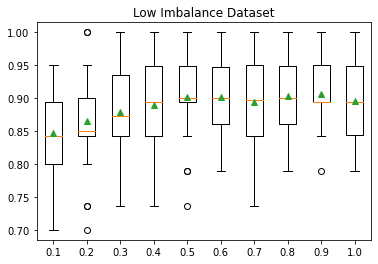

KFOLD:  2
>0.1 0.857 (0.070)
>0.2 0.873 (0.070)
>0.3 0.894 (0.059)
>0.4 0.893 (0.065)
>0.5 0.886 (0.073)
>0.6 0.897 (0.069)
>0.7 0.891 (0.068)
>0.8 0.891 (0.061)
>0.9 0.896 (0.069)
>1.0 0.905 (0.064)


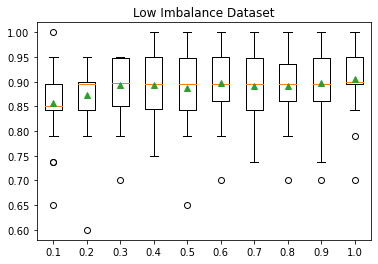

KFOLD:  3
>0.1 0.874 (0.072)
>0.2 0.888 (0.066)
>0.3 0.888 (0.072)
>0.4 0.896 (0.062)
>0.5 0.903 (0.075)
>0.6 0.908 (0.047)
>0.7 0.910 (0.059)
>0.8 0.912 (0.056)
>0.9 0.907 (0.062)
>1.0 0.912 (0.058)


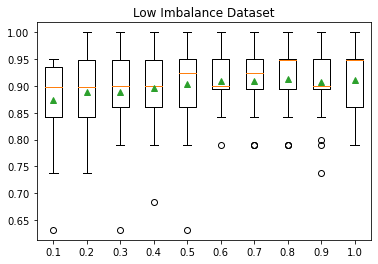

KFOLD:  4
>0.1 0.870 (0.073)
>0.2 0.872 (0.073)
>0.3 0.872 (0.062)
>0.4 0.890 (0.071)
>0.5 0.904 (0.073)
>0.6 0.902 (0.072)
>0.7 0.899 (0.071)
>0.8 0.904 (0.069)
>0.9 0.903 (0.077)
>1.0 0.911 (0.073)


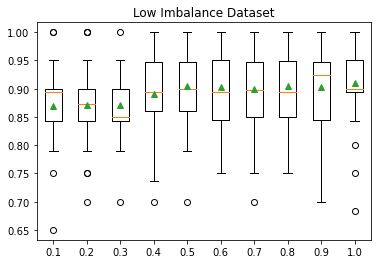

KFOLD:  5
>0.1 0.851 (0.076)
>0.2 0.859 (0.076)
>0.3 0.876 (0.078)
>0.4 0.868 (0.082)
>0.5 0.872 (0.080)
>0.6 0.871 (0.083)
>0.7 0.879 (0.068)
>0.8 0.881 (0.072)
>0.9 0.874 (0.072)
>1.0 0.879 (0.078)


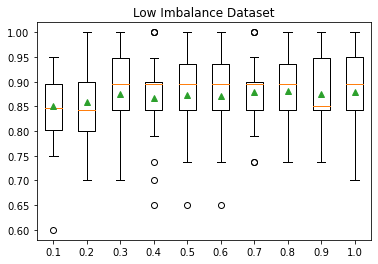

KFOLD:  6
>0.1 0.863 (0.068)
>0.2 0.875 (0.062)
>0.3 0.869 (0.061)
>0.4 0.875 (0.064)
>0.5 0.880 (0.064)
>0.6 0.885 (0.053)
>0.7 0.883 (0.058)
>0.8 0.886 (0.066)
>0.9 0.880 (0.061)
>1.0 0.895 (0.054)


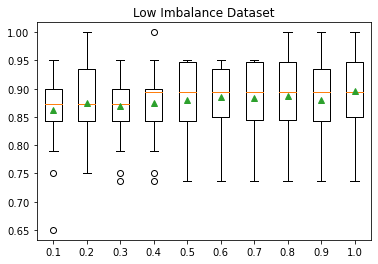

KFOLD:  7
>0.1 0.868 (0.054)
>0.2 0.890 (0.060)
>0.3 0.890 (0.065)
>0.4 0.894 (0.061)
>0.5 0.904 (0.054)
>0.6 0.908 (0.048)
>0.7 0.908 (0.059)
>0.8 0.899 (0.058)
>0.9 0.906 (0.060)
>1.0 0.916 (0.058)


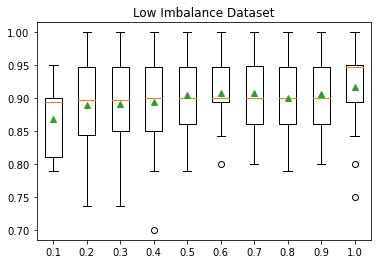

KFOLD:  8
>0.1 0.850 (0.052)
>0.2 0.877 (0.056)
>0.3 0.865 (0.068)
>0.4 0.882 (0.063)
>0.5 0.891 (0.061)
>0.6 0.887 (0.061)
>0.7 0.894 (0.057)
>0.8 0.897 (0.056)
>0.9 0.879 (0.060)
>1.0 0.889 (0.051)


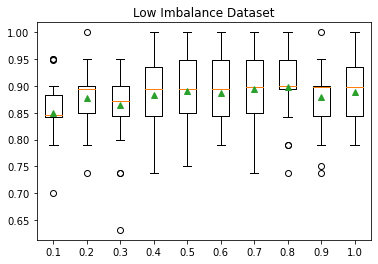

KFOLD:  9
>0.1 0.841 (0.073)
>0.2 0.865 (0.074)
>0.3 0.865 (0.068)
>0.4 0.884 (0.059)
>0.5 0.892 (0.060)
>0.6 0.884 (0.065)
>0.7 0.896 (0.059)
>0.8 0.891 (0.062)
>0.9 0.899 (0.052)
>1.0 0.884 (0.060)


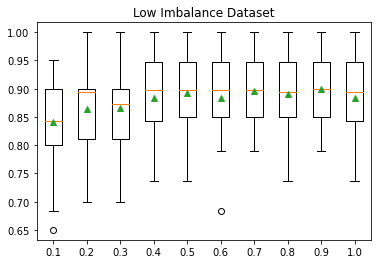

KFOLD:  10


In [138]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_low = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_low.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("Low Imbalance Dataset")
        plt.show()

Medium Imbalance Dataset
KFOLD:  1
>0.1 0.839 (0.067)
>0.2 0.863 (0.073)
>0.3 0.861 (0.066)
>0.4 0.867 (0.074)
>0.5 0.869 (0.065)
>0.6 0.878 (0.064)
>0.7 0.871 (0.078)
>0.8 0.878 (0.066)
>0.9 0.879 (0.061)
>1.0 0.869 (0.065)


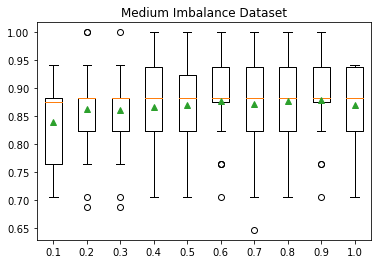

KFOLD:  2
>0.1 0.823 (0.073)
>0.2 0.849 (0.078)
>0.3 0.875 (0.077)
>0.4 0.871 (0.079)
>0.5 0.875 (0.065)
>0.6 0.875 (0.080)
>0.7 0.887 (0.074)
>0.8 0.865 (0.070)
>0.9 0.891 (0.072)
>1.0 0.887 (0.080)


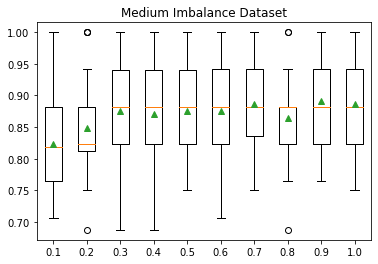

KFOLD:  3
>0.1 0.840 (0.068)
>0.2 0.854 (0.072)
>0.3 0.862 (0.079)
>0.4 0.873 (0.066)
>0.5 0.873 (0.070)
>0.6 0.879 (0.056)
>0.7 0.873 (0.066)
>0.8 0.873 (0.058)
>0.9 0.871 (0.070)
>1.0 0.879 (0.069)


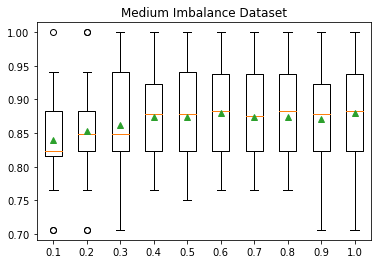

KFOLD:  4
>0.1 0.845 (0.073)
>0.2 0.869 (0.081)
>0.3 0.877 (0.079)
>0.4 0.883 (0.081)
>0.5 0.901 (0.076)
>0.6 0.893 (0.074)
>0.7 0.891 (0.073)
>0.8 0.887 (0.078)
>0.9 0.881 (0.085)
>1.0 0.881 (0.082)


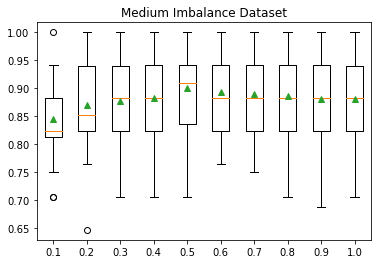

KFOLD:  5
>0.1 0.840 (0.062)
>0.2 0.865 (0.057)
>0.3 0.877 (0.068)
>0.4 0.872 (0.068)
>0.5 0.881 (0.066)
>0.6 0.881 (0.064)
>0.7 0.877 (0.060)
>0.8 0.879 (0.064)
>0.9 0.873 (0.064)
>1.0 0.867 (0.071)


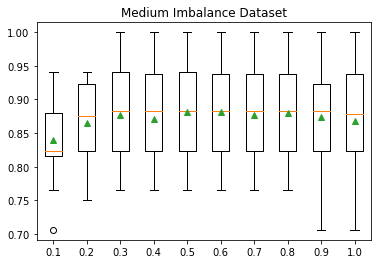

KFOLD:  6
>0.1 0.848 (0.067)
>0.2 0.879 (0.051)
>0.3 0.881 (0.045)
>0.4 0.873 (0.056)
>0.5 0.873 (0.049)
>0.6 0.858 (0.058)
>0.7 0.860 (0.055)
>0.8 0.865 (0.060)
>0.9 0.864 (0.064)
>1.0 0.864 (0.050)


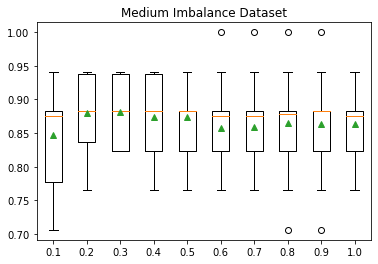

KFOLD:  7
>0.1 0.836 (0.069)
>0.2 0.845 (0.058)
>0.3 0.859 (0.070)
>0.4 0.859 (0.066)
>0.5 0.865 (0.072)
>0.6 0.855 (0.067)
>0.7 0.853 (0.063)
>0.8 0.853 (0.063)
>0.9 0.857 (0.066)
>1.0 0.859 (0.061)


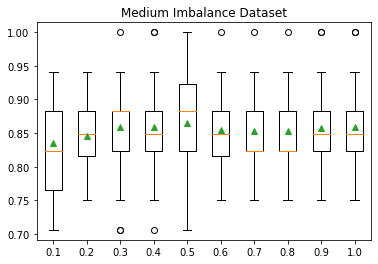

KFOLD:  8
>0.1 0.840 (0.070)
>0.2 0.876 (0.055)
>0.3 0.863 (0.079)
>0.4 0.874 (0.055)
>0.5 0.876 (0.052)
>0.6 0.872 (0.060)
>0.7 0.866 (0.068)
>0.8 0.870 (0.062)
>0.9 0.868 (0.066)
>1.0 0.860 (0.078)


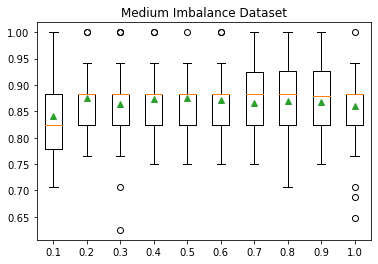

KFOLD:  9
>0.1 0.856 (0.069)
>0.2 0.858 (0.064)
>0.3 0.868 (0.064)
>0.4 0.872 (0.063)
>0.5 0.874 (0.060)
>0.6 0.888 (0.061)
>0.7 0.878 (0.069)
>0.8 0.882 (0.064)
>0.9 0.872 (0.066)
>1.0 0.880 (0.069)


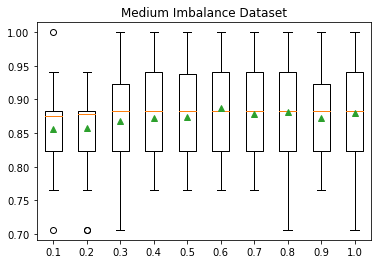

KFOLD:  10


In [139]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_medium = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_medium.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("Medium Imbalance Dataset")
        plt.show()

High Imbalance Dataset
KFOLD:  1
>0.1 0.913 (0.028)
>0.2 0.913 (0.028)
>0.3 0.913 (0.028)
>0.4 0.910 (0.029)
>0.5 0.915 (0.026)
>0.6 0.927 (0.026)
>0.7 0.935 (0.039)
>0.8 0.942 (0.034)
>0.9 0.945 (0.040)
>1.0 0.940 (0.038)


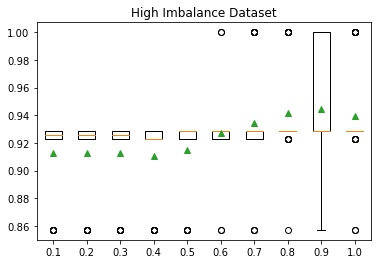

KFOLD:  2
>0.1 0.913 (0.028)
>0.2 0.913 (0.028)
>0.3 0.913 (0.028)
>0.4 0.923 (0.041)
>0.5 0.927 (0.041)
>0.6 0.932 (0.037)
>0.7 0.944 (0.040)
>0.8 0.944 (0.040)
>0.9 0.947 (0.037)
>1.0 0.947 (0.037)


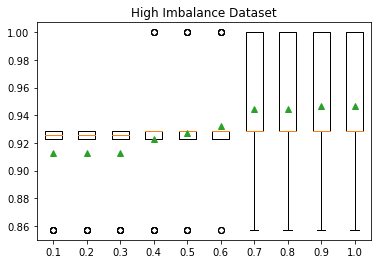

KFOLD:  3
>0.1 0.913 (0.028)
>0.2 0.913 (0.028)
>0.3 0.915 (0.032)
>0.4 0.920 (0.033)
>0.5 0.932 (0.037)
>0.6 0.942 (0.039)
>0.7 0.949 (0.038)
>0.8 0.949 (0.038)
>0.9 0.954 (0.040)
>1.0 0.947 (0.037)


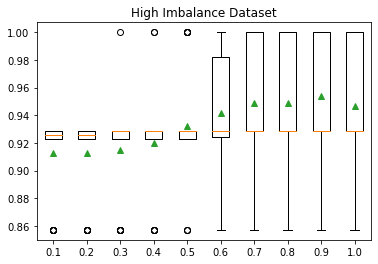

KFOLD:  4
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.906 (0.032)
>0.4 0.913 (0.038)
>0.5 0.921 (0.046)
>0.6 0.921 (0.046)
>0.7 0.933 (0.049)
>0.8 0.935 (0.047)
>0.9 0.940 (0.053)
>1.0 0.933 (0.056)


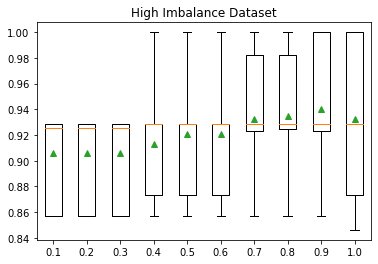

KFOLD:  5
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.906 (0.032)
>0.4 0.913 (0.056)
>0.5 0.918 (0.060)
>0.6 0.923 (0.058)
>0.7 0.923 (0.055)
>0.8 0.928 (0.055)
>0.9 0.928 (0.061)
>1.0 0.923 (0.055)


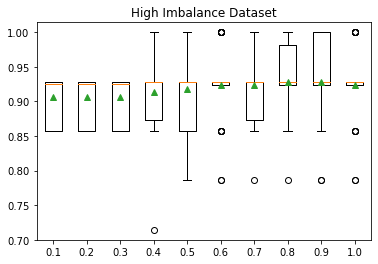

KFOLD:  6
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.906 (0.032)
>0.4 0.908 (0.036)
>0.5 0.911 (0.040)
>0.6 0.918 (0.040)
>0.7 0.928 (0.049)
>0.8 0.925 (0.043)
>0.9 0.925 (0.047)
>1.0 0.930 (0.047)


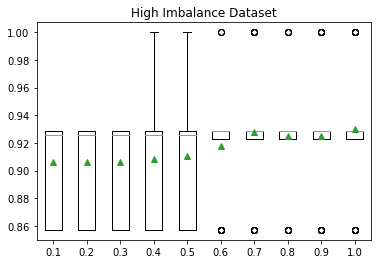

KFOLD:  7
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.908 (0.036)
>0.4 0.911 (0.035)
>0.5 0.921 (0.046)
>0.6 0.925 (0.043)
>0.7 0.928 (0.049)
>0.8 0.940 (0.049)
>0.9 0.937 (0.040)
>1.0 0.937 (0.051)


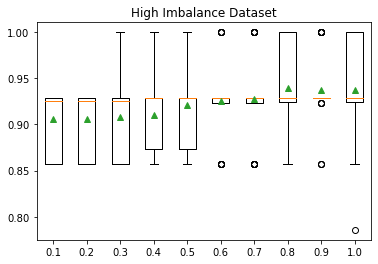

KFOLD:  8
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.906 (0.032)
>0.4 0.911 (0.040)
>0.5 0.916 (0.037)
>0.6 0.923 (0.041)
>0.7 0.930 (0.039)
>0.8 0.933 (0.045)
>0.9 0.930 (0.051)
>1.0 0.930 (0.043)


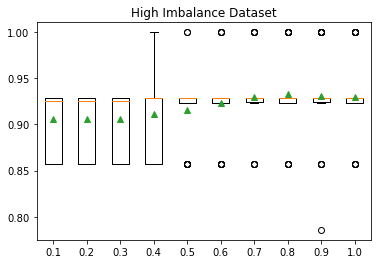

KFOLD:  9
>0.1 0.906 (0.032)
>0.2 0.906 (0.032)
>0.3 0.913 (0.043)
>0.4 0.918 (0.044)
>0.5 0.918 (0.044)
>0.6 0.923 (0.045)
>0.7 0.932 (0.045)
>0.8 0.935 (0.047)
>0.9 0.942 (0.043)
>1.0 0.950 (0.046)


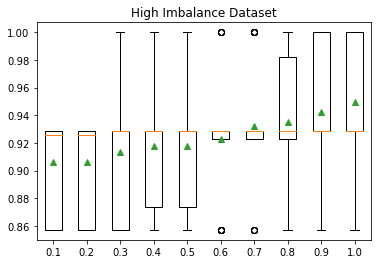

KFOLD:  10


In [140]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_high = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_high.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("High Imbalance Dataset")
        plt.show()

### Use unseen fold - 10th Fold <a class="anchor" id="4.4"></a>
    E. Given a sample xi from the unseen fold (the one left out in (3))
        a. Assign xi to its closest cluster.
        b. this cluster has only instances of one class, assign to xi that label. Otherwise, use the model trained with data from that cluster to assign a label to xi
[Task 04](#4)

#### 10th Fold from the Low Imbalance Dataset

Ideal: 0.500
> folds=2, accuracy=0.507 (0.290,0.725)
> folds=3, accuracy=0.377 (0.239,0.630)
> folds=4, accuracy=0.526 (0.324,0.743)
> folds=5, accuracy=0.435 (0.250,0.714)
> folds=6, accuracy=0.493 (0.261,0.783)
> folds=7, accuracy=0.438 (0.200,0.737)
> folds=8, accuracy=0.651 (0.353,0.882)
> folds=9, accuracy=0.636 (0.333,0.867)
> folds=10, accuracy=0.380 (0.143,0.692)


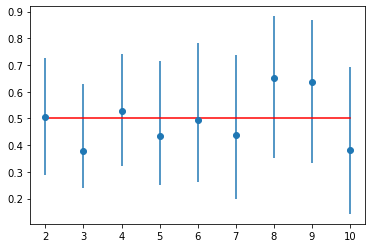

In [141]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_low10, y_train_low10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

#### 10th Fold from the Medium Imbalance Dataset

Ideal: 0.550
> folds=2, accuracy=0.248 (0.202,0.294)
> folds=3, accuracy=0.752 (0.679,0.839)
> folds=4, accuracy=0.466 (0.143,0.738)
> folds=5, accuracy=0.570 (0.176,0.848)
> folds=6, accuracy=0.492 (0.179,0.821)
> folds=7, accuracy=0.532 (0.083,0.833)
> folds=8, accuracy=0.562 (0.143,0.810)
> folds=9, accuracy=0.579 (0.167,0.947)
> folds=10, accuracy=0.599 (0.235,0.882)


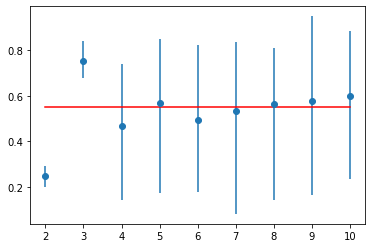

In [142]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_medium10, y_train_medium10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

#### 10th Fold from the High Imbalance Dataset

Ideal: 0.428
> folds=2, accuracy=0.326 (0.290,0.362)
> folds=3, accuracy=0.543 (0.283,0.717)
> folds=4, accuracy=0.448 (0.235,0.743)
> folds=5, accuracy=0.646 (0.393,0.750)
> folds=6, accuracy=0.370 (0.217,0.652)
> folds=7, accuracy=0.479 (0.263,0.850)
> folds=8, accuracy=0.545 (0.167,0.765)
> folds=9, accuracy=0.525 (0.125,0.800)
> folds=10, accuracy=0.550 (0.308,0.929)


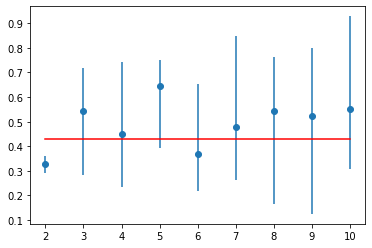

In [143]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_high10, y_train_high10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

### Task 05 <a class="anchor" id="5"></a>
[Table of Contents](#0)

5. Do the above for each permutation of 10 bins (like in cross-validation), and present the average and standard deviation of results for each of the datasets and their surrogates using appropriate metric/s.

In [253]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_low10, perm_scores_Fold_low10, pvalue_Fold_low10 = permutation_test_score(
    model, X_train_low10, y_train_low10, scoring="accuracy", cv=cv, n_permutations=100
)

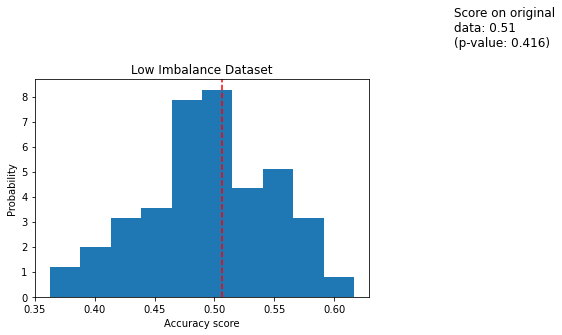

In [255]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_low10, bins=10, density=True)
ax.axvline(score_Fold_low10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_low10:.2f}\n(p-value: {pvalue_Fold_low10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("Low Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

plt.savefig('fig13_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.pdf')
plt.savefig('fig13_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.png')

In [256]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_medium10, perm_scores_Fold_medium10, pvalue_Fold_medium10 = permutation_test_score(
    model, X_train_medium10, y_train_medium10, scoring="accuracy", cv=cv, n_permutations=100
)

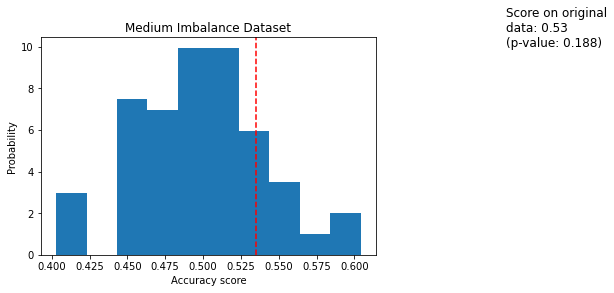

In [259]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_medium10, bins=10, density=True)
ax.axvline(score_Fold_medium10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_medium10:.2f}\n(p-value: {pvalue_Fold_medium10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("Medium Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

plt.savefig('fig14_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.pdf')
plt.savefig('fig14_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.png')

In [260]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_high10, perm_scores_Fold_high10, pvalue_Fold_high10 = permutation_test_score(
    model, X_train_high10, y_train_high10, scoring="accuracy", cv=cv, n_permutations=100
)

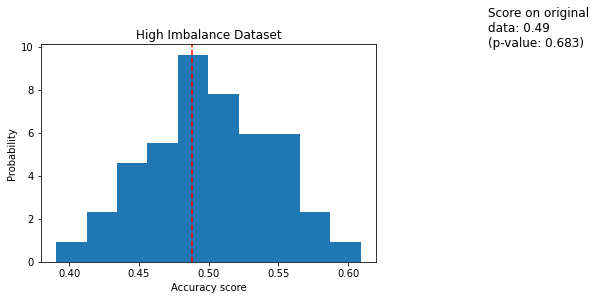

In [261]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_high10, bins=10, density=True)
ax.axvline(score_Fold_high10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_high10:.2f}\n(p-value: {pvalue_Fold_high10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("High Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

plt.savefig('fig15_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.pdf')
plt.savefig('fig15_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.png')

### Task 06 <a class="anchor" id="6"></a>
[Table of Contents](#0)

6. Compare your results with the baseline results from (2). A boxplot of the cross-validation results for each method should help you decide which method is best under which conditions. Are the results significantly better with the new method (e.g., as determined by a permutation test)? How does the data imbalance affect the results?

KMeans: 0.526407 (0.197501)
RF: 0.901948 (0.068277)


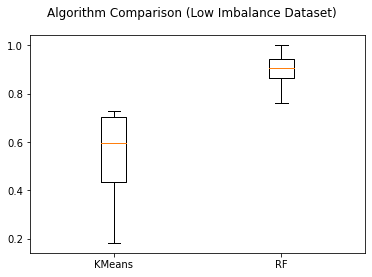

In [265]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_low()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Low Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

plt.savefig('fig22_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_low.pdf')
plt.savefig('fig22_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_low.png')
plt.show()

KMeans: 0.536257 (0.277501)
RF: 0.920468 (0.063643)


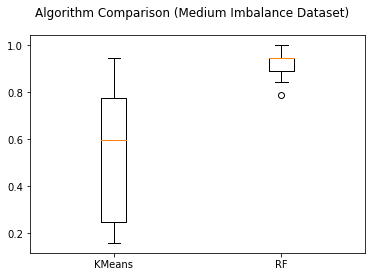

In [266]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_medium()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Medium Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

plt.savefig('fig23_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_medium.pdf')
plt.savefig('fig23_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_medium.png')

plt.show()

KMeans: 0.394583 (0.199322)
RF: 0.935000 (0.056893)


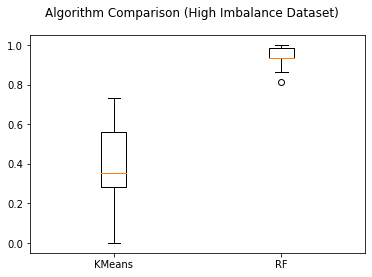

In [267]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_high()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (High Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('fig24_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_high.pdf')
plt.savefig('fig24_heart_attack_accuracy_metrics_bar_graphs_Curve_kmeans_high.png')

plt.show()

[Move to Top](#0.1)